# Pattern exploration
---

In [386]:
from IPython.display import SVG
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy import sparse
import seaborn as sns

from sknetwork.data import load_netset
from sknetwork.topology import get_connected_components
from sknetwork.utils import get_degrees
from sknetwork.visualization import svg_graph

In [517]:
def load_data(dataset: str):
    """Load data and return loaded elements as a tuple.
    
    Parameters
    ----------
    dataset: str
        Name of dataset (on netset or local).
    """
    netset = ['wikivitals-fr', 'wikischools', 'wikivitals', 'wikihumans']
    labels = ''

    if dataset in netset:
        graph = load_netset(dataset)
        if dataset != 'wikihumans':
            labels = graph.labels

    else:
        with open(f'../data/{dataset}Graph', 'br') as f:
            graph = pickle.load(f)

    adjacency = graph.adjacency
    biadjacency = graph.biadjacency
    names = graph.names
    names_col = graph.names_col
    
    return adjacency, biadjacency, names, names_col, labels

In [281]:
def preprocess_data(biadjacency, names_col, s, sort_data=True):
    # Frequent attributes
    freq_attribute = get_degrees(biadjacency.astype(bool), transpose=True)
    index = np.flatnonzero((freq_attribute <= 1000) & (freq_attribute >= s))

    # Filter data with index
    biadjacency = biadjacency[:, index]
    words = names_col[index]
    freq_attribute = freq_attribute[index]
    
    # Sort data
    if sort_data:
        sort_index = np.argsort(freq_attribute)
        sorted_biadjacency = biadjacency[:, sort_index]
        words = words[sort_index]
    else:
        sorted_biadjacency = biadjacency.copy()

    return sorted_biadjacency, words

def get_pattern(patterns, i):
    return patterns[i][0], patterns[i][1]

def display_pattern(adjacency, nodes, names, labels):
    if len(labels)==0:
        return SVG(svg_graph(adjacency[nodes, :][:, nodes] + sparse.identity(len(nodes)), names=names[nodes], edge_width_max=1))
    else:
        return SVG(svg_graph(adjacency[nodes, :][:, nodes] + sparse.identity(len(nodes)), names=names[nodes], labels=labels[nodes], edge_width_max=1))

In [11]:
import gensim

class MyCorpus():
    """A memory-friendly iterator that yields documents as TaggedDocument objects, i.e tokens associated with index of document."""
    
    def __init__(self, data, vocab, tokens_only=False):
        self.data = data
        self.vocab = vocab
        self.tokens_only = tokens_only
    
    def __iter__(self):
        if isinstance(self.data, sparse.csr_matrix):
            for i, x in enumerate(self.data):
                tokens = list(self.vocab[x.indices])
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])
        else:
            if not self.tokens_only:
                for i, x in enumerate(self.data):
                    tokens = list(self.vocab[np.flatnonzero(x)])
                    yield gensim.models.doc2vec.TaggedDocument(tokens, [i])
            else:
                for i, x in enumerate(self.data):
                    tokens = list(self.vocab[np.flatnonzero(x)])
                    yield tokens

## Parameters  

Select:
- dataset: either `wikivitals`, `wikivitals-fr` or `wikischools`
- $s$ and $\beta$: support parameters (here 5)
- order_attributes: initial ordering of attributes (here True)

In [296]:
# Parameters for UnexPatterns
dataset = 'lastfm'
s = 4
beta = 4
order_attributes = True

**Load graph data and preprocess it (e.g attribute ordering)**

In [297]:
# Load data
adjacency, biadjacency, names, names_col, labels = load_data(dataset)

# Preprocess data (get same attribute order as in UnexPattern)
new_biadjacency, words = preprocess_data(biadjacency, names_col, s)

**Load `UnexPatterns` output**

Output of algorithm is a list of patterns, i.e. a list of tuples (nodes, attributes).

In [1093]:
inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG'

with open(f'{inpath}/result_{dataset}_{beta}_{s}_order{str(order_attributes)}_prob.bin', 'rb') as data:
    res = pickle.load(data)

In [1094]:
print(f'Number of patterns found: {len(res)}')

Number of patterns found: 2463


In [1095]:
# First pattern (pattern of index 0 is the starting point of lattice)
idx = 1 #np.random.choice(len(res))
print(res[idx])

nodes = res[idx][0]
attributes = res[idx][1]
print(names[nodes], words[attributes])

([518, 567, 2354, 2865], [1, 1992, 7496, 9907, 10123, 10125, 10168, 10203, 10238, 10256, 10261, 10288, 10329])
['Bolivia' 'Peru' 'Bogotá' 'Simón Bolívar'] ['simón' 'bolívar' 'colombia' 'spanish' 'presid' 'latin' 'de' 'listen'
 'territori' 'empir' 'america' 'independ' 'polit']


**Display pattern**

Pattern index: 1173
Attributes: ['chester' 'german' 'ii' 'war' 'becam']


/var/folders/hb/p2nvp7cj1dg6y96zlm9vqb2c0000gn/T/ipykernel_22700/3453224079.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labels=='':


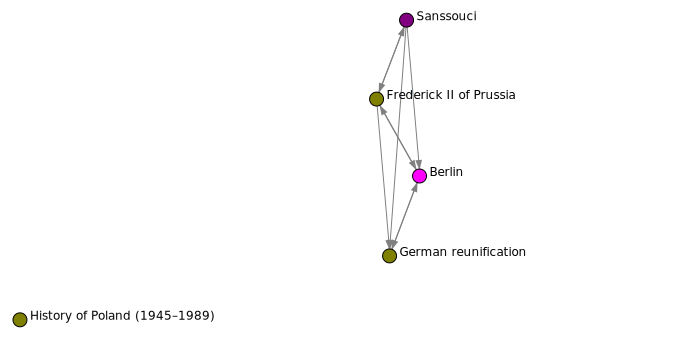

In [1104]:
# Random pattern
idx = np.random.choice(len(res))
nodes, attributes = get_pattern(res, idx)

print(f'Pattern index: {idx}')
print(f'Attributes: {words[attributes]}')

# Display pattern
display_pattern(adjacency, nodes, names, labels)

## Patterns from keywords

Select pattern related to specific keywords, i.e. patterns that contain **at least one** keyword in list.

In [1105]:
def get_patterns(patterns, keyword, words):
    res = []
    for p in patterns:
        for w in keywords:
            index = np.argwhere(words==w)
            if len(index) > 0:
                if int(index) in p[1]:
                    res.append(p)
                    break
            else:
                raise Exception(f'keyword: {w} is not found.')
    return res

In [1106]:
valid_words = np.unique(np.asarray([words[w] for p in res for w in p[1]]))
print(len(valid_words))

2471


In [1107]:
# Select keywords
#print(f'Some random words to get inspiration: {np.random.choice(words, 15)}')
print(f'Some random words to get inspiration: {np.random.choice(valid_words, 15)}')

Some random words to get inspiration: ['gottlieb' 'snow' 'inland' 'compani' 'becom' 'commonwealth' 'older'
 'inact' 'zone' 'mudflat' 'plan' 'extend' 'cataract' 'geolog' 'often']


In [1108]:
# Chose keywords
keywords = ['snow', 'commonwealth']

In [1109]:
kw_patterns = get_patterns(res, keywords, words)
print(f'Number of patterns related to {keywords}: {len(kw_patterns)}')

Number of patterns related to ['snow', 'commonwealth']: 5


Attributes of patter: ['toughest' 'snow' 'retir' 'asia' 'empir' 'central' 'europ' 'led'
 'histori' 'power']


/var/folders/hb/p2nvp7cj1dg6y96zlm9vqb2c0000gn/T/ipykernel_22700/3453224079.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labels=='':


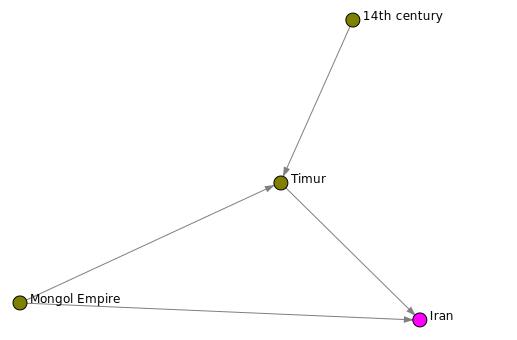

In [1110]:
first_pattern = get_pattern(kw_patterns, 0)

print(f'Attributes of patter: {words[first_pattern[1]]}')
display_pattern(adjacency, first_pattern[0], names, labels)

Attributes of pattern 3/4: ['hindustani' 'sun' 'commonwealth' 'tropic' 'rank']


/var/folders/hb/p2nvp7cj1dg6y96zlm9vqb2c0000gn/T/ipykernel_22700/3453224079.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labels=='':


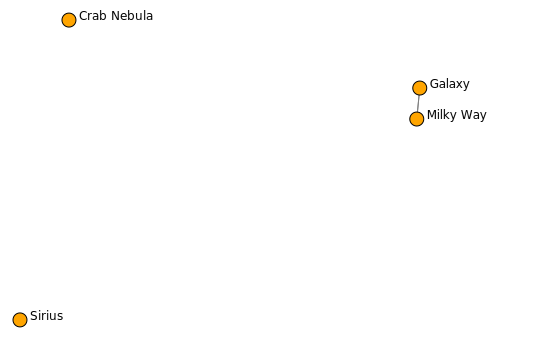

In [1111]:
idx = np.random.choice(len(kw_patterns))
rand_pattern = get_pattern(kw_patterns, idx)

print(f'Attributes of pattern {idx}/{len(kw_patterns)-1}: {words[rand_pattern[1]]}')
display_pattern(adjacency, rand_pattern[0], names, labels)

## Pattern summaries from keywords 

In [383]:
def get_summarized_graph(adjacency, patterns):
    """Get summarized graph given patterns and original adjacency matrix."""
    
    rows, cols = [], []

    for p in patterns:

        # exclude first element of lattice 
        if len(p[1]) > 0:
            nodes = sorted(p[0])
            idx = 0
            idx_nodes = np.array([-1] * len(nodes)) # number of unique nodes from concepts
            # reindex nodes
            for n in nodes:
                if n not in idx_nodes:
                    idx_nodes[idx] = n
                    idx += 1
            
            # Record edges from subgraph related to concept
            adj_pattern = adjacency[nodes, :][:, nodes].tocoo()
            reindex_rows = [int(idx_nodes[src]) for src in adj_pattern.row]
            reindex_cols = [int(idx_nodes[dst]) for dst in adj_pattern.col]
            rows += reindex_rows
            cols += reindex_cols
            
    return sparse.coo_matrix((np.ones(len(rows)), (rows, cols)), shape=adjacency.shape).tocsr()

def get_summarized_biadjacency(adjacency, biadjacency, patterns):
    summarized_biadj = np.zeros((adjacency.shape[0], biadjacency.shape[1]))
    for p in patterns:
        if len(p[1]) > 0:
            for node in p[0]:
                summarized_biadj[node, p[1]] += 1

    summarized_biadj = sparse.csr_matrix(summarized_biadj.astype(bool), shape=summarized_biadj.shape)
    return summarized_biadj

In [1220]:
def display_pattern_summary(summarized_adjacency, summarized_biadjacency, mask, labels_cc, idx, names, names_col, labels, width=500, height=500):
    mask_cc = labels_cc == idx
    g = summarized_adjacency[mask, :][:, mask]
    g_cc = g[mask_cc, :][:, mask_cc]
    
    attributes = np.unique(summarized_biadj[mask, :][mask_cc, :].indices)
    print(f'Attributes: {names_col[attributes]}')
    
    if labels=='':
        return SVG(svg_graph(g_cc + sparse.identity(g_cc.shape[0]), names=names[mask][mask_cc], 
              edge_width_min=0.5, edge_width_max=0.5, width=width, height=height))
    else:
        return SVG(svg_graph(g_cc + sparse.identity(g_cc.shape[0]), names=names[mask][mask_cc], 
              edge_width_min=0.5, edge_width_max=0.5, width=width, height=height, labels=labels[mask][mask_cc]))

**Summarized graph**

In [1114]:
# Build summarized adjacency matrix, i.e. adjacency matrix of the union of all patterns found with UnexPatterns
summarized_adj = get_summarized_graph(adjacency, res)
summarized_adj

<4403x4403 sparse matrix of type '<class 'numpy.float64'>'
	with 2390 stored elements in Compressed Sparse Row format>

In [1115]:
# Build summarized biadjacency matrix
summarized_biadj = get_summarized_biadjacency(adjacency, new_biadjacency, res)
summarized_biadj

<4403x10383 sparse matrix of type '<class 'numpy.bool_'>'
	with 26182 stored elements in Compressed Sparse Row format>

**Pattern summaries**

In [1116]:
# Summarized graph filtered on used nodes
mask = np.flatnonzero(summarized_adj.astype(bool).dot(np.ones(summarized_adj.shape[1])))

# Number of connected components (NOT considering isolated nodes)
labels_cc_summarized = get_connected_components(summarized_adj[mask, :][:, mask])
nb_cc = len(np.unique(labels_cc_summarized)) 

print(f'Number of pattern summaries: {nb_cc}')

Number of pattern summaries: 135


In [1225]:
# Biggest pattern summaries (index of pattern, nb nodes)
sorted(dict(Counter(labels_cc_summarized)).items(), key=lambda x: x[1], reverse=True)[:10]

[(2, 228),
 (11, 111),
 (1, 58),
 (75, 33),
 (15, 25),
 (17, 25),
 (30, 20),
 (35, 17),
 (55, 17),
 (0, 15)]

Pattern summary: 1
Attributes: ['succumb' 'romulu' 'lepidu' 'soter' 'fife' 'corvu' 'barrist' 'horac'
 'sewn' 'reconquest' 'theoriz' 'brexit' 'existenti' 'irrepar' 'cadillac'
 'distinctli' 'unparallel' 'delight' 'her' 'hernán' 'brambl' 'hemoglobin'
 'phenotyp' 'eland' 'sevastopol' 'eratosthen' 'welbi' 'repositori'
 'escarp' 'heath' 'triumvir' 'paramagnet' 'fédération' 'untreat' 'akin'
 'محمد' 'thicken' 'yugoslav' 'mlb' 'władysław' 'palat' 'grung' 'germania'
 'gravel' 'fixtur' 'octavia' 'actium' 'ra' 'allah' 'sunda' 'transvaal'
 'ftse' 'harem' 'electrifi' 'octavian' 'quadruped' 'leftist' 'wrong' 'fa'
 'inact' 'isabella' 'stalk' 'shrine' 'titular' 'reveng' 'marcu' 'unix'
 'devil' 'gnu' 'transactinid' 'replic' 'burrow' 'antoni' 'fluoresc' 'noth'
 'northward' 'tribal' 'thinker' 'berber' 'ancestri' 'caesar' 'slavic'
 'suspect' 'client' 'disintegr' 'iberian' 'normandi' 'imagin' 'shark'
 'buddhist' 'beneath' 'feudal' 'juliu' 'frontier' 'lanka' 'suicid' 'boom'
 'chairman' 'physiolog' 'eldest' '

/var/folders/hb/p2nvp7cj1dg6y96zlm9vqb2c0000gn/T/ipykernel_22700/706547866.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labels=='':


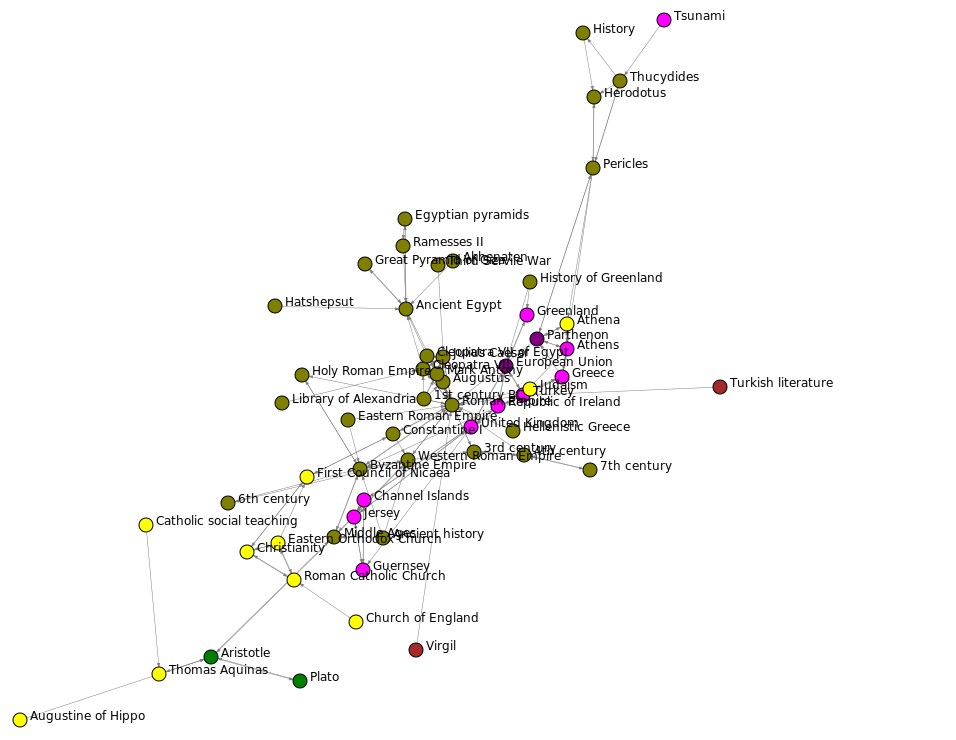

In [1236]:
# Display random pattern summary
idx = 1
print(f'Pattern summary: {idx}')
display_pattern_summary(summarized_adj, summarized_biadj, mask, labels_cc_summarized, idx, names, words, labels, width=700, height=700)

Pattern summary: 95
Attributes: ['suðreyjar' 'tycoon' 'regia' 'jurisprud' 'sure' 'decolon' 'croft' 'osama'
 'decod' 'steril' 'southampton' 'coldest' 'quartz' 'hebrid' 'maker'
 'papua' 'fring' 'azerbaijan' 'logic' 'nors' 'smith' 'lincoln' 'toler'
 'gaelic' 'want' 'similarli' 'prehistor' 'adjac' 'guinea' 'inner' 'rival'
 'stretch' 'outer' 'prepar' 'archipelago' 'tour' 'poet' 'scottish'
 'parliamentari' 'tourism' 'speed' 'basin' 'mainland' 'hard' 'rapidli'
 'ga' 'test' 'scotland' 'face' 'fish' 'declin' 'varieti' 'coast' 'other'
 'servic' 'island' 'languag' 'kingdom' 'western' 'west' 'east' 'refer'
 'major']


/var/folders/hb/p2nvp7cj1dg6y96zlm9vqb2c0000gn/T/ipykernel_22700/4041998973.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labels=='':


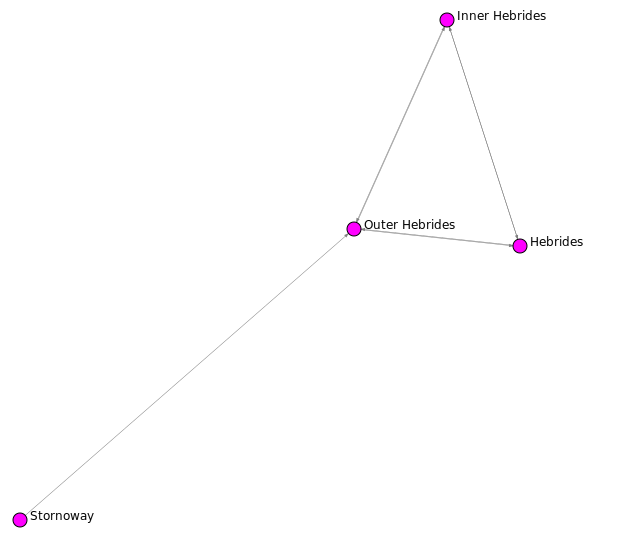

In [1047]:
# Display random pattern summary
idx = np.random.choice(nb_cc)
print(f'Pattern summary: {idx}')
display_pattern_summary(summarized_adj, summarized_biadj, mask, labels_cc_summarized, idx, names, words, labels)

In [527]:
inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG'

with open(f'{inpath}/output/result/wasserstein_distances_{dataset}_{beta}_{s}_summaries.pkl', 'rb') as data:
    pw_distances = np.load(data)

In [530]:
pw_distances[pw_distances > 0.02]

1668

In [534]:
diversity(pw_distances, delta=0.2)

0.0

In [536]:
np.max(pw_distances)

0.17378258472657765

## Sias-Miner exploration

In [259]:
import json

inpath = '/Users/simondelarue/Downloads/Mining_Subjectively_Interesting_Attributed_Subgraphs/siasminer/Executable'

with open(f'{inpath}/resultsLastfm/results.json', 'rb') as f:
    data = json.load(f)

In [261]:
data.keys()

dict_keys(['numberOfPatterns', 'patterns'])

In [265]:
# Number of patterns with SIAS Miner (minVertices=100, maxDistance=1)
len(data.get('patterns'))

1184

In [457]:
def get_sias_pattern(pattern: dict):
    
    # get subgraph
    subgraph_nodes = np.asarray(list(map(int, pattern.get('subgraph'))))
    
    # get attributes
    pos_attrs = set(pattern.get('characteristic').get('positiveAttributes'))
    neg_attrs = set(pattern.get('characteristic').get('negativeAttributes'))
    attrs = np.asarray([int(x.split('>=')[0]) for x in pos_attrs.union(neg_attrs)])
    
    return subgraph_nodes, attrs

In [458]:
# List of all sias patterns
nb_sias_patterns = len(data.get('patterns'))

sias_patterns = [get_sias_pattern(data.get('patterns')[idx]) for idx in range(nb_sias_patterns)]

In [463]:
sias_patterns[5]

(array([ 796, 1466, 1059, 1157,  237, 1121,  772, 1502, 1688, 1772, 1702,
         514,  625,  708, 1032, 1394,  394, 1139, 1089,  793,  279, 1087,
         417, 1777,  371, 1365,  607, 1540,  693, 1019, 1605,  205,  703,
         296,  278,  741,   67,  615,  752,  220, 1058, 1100, 1122, 1712,
          36,  114,  459,  778, 1178, 1242, 1263, 1735, 1128,  103,  671,
         676,  572,  761, 1120, 1230,  822, 1154, 1622, 1803,  340,  396,
        1151,   19,  813,  428,  743,  422,  151, 1054,  200, 1653, 1685,
         343, 1260,  287, 1324, 1381,  288, 1699, 1576, 1736,  122, 1841,
         596, 1543, 1816, 1164,   56, 1696, 1443, 1000,  236,  857,  970,
         505,  936, 1249,  846]),
 array([45, 41, 13, 24]))

Attributes: ['jim morrison' 'amy winehouse' 'tags']


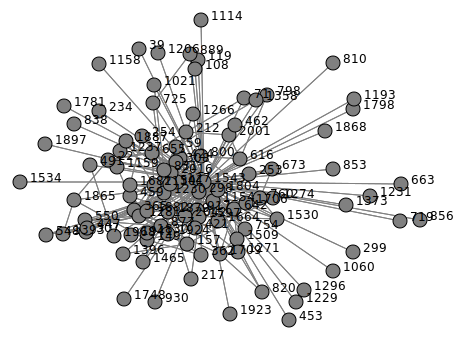

In [472]:
# Display pattern
idx = np.random.choice(len(data.get('patterns')))

node_idx, attr_idx = get_sias_pattern(data.get('patterns')[idx])

print(f'Attributes: {words[attr_idx]}')

display_pattern(adjacency, node_idx, names, labels)

**Patterns x attributes matrix**

In [473]:
nb_sias_patterns = len(data.get('patterns'))

sias_patterns_attributes = np.zeros((nb_sias_patterns, biadjacency.shape[1]))
for i, p in enumerate(sias_patterns):
    sias_patterns_attributes[i, p[1]] = 1

In [474]:
sias_patterns_attributes.shape

(1184, 9749)

**Doc2Vec model**

In [480]:
import gensim

class MyCorpus():
    """A memory-friendly iterator that yields documents as TaggedDocument objects, i.e tokens associated with index of document."""
    
    def __init__(self, data, vocab, tokens_only=False):
        self.data = data
        self.vocab = vocab
        self.tokens_only = tokens_only
    
    def __iter__(self):
        if isinstance(self.data, sparse.csr_matrix):
            for i, x in enumerate(self.data):
                tokens = list(self.vocab[x.indices])
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])
        else:
            if not self.tokens_only:
                for i, x in enumerate(self.data):
                    tokens = list(self.vocab[np.flatnonzero(x)])
                    yield gensim.models.doc2vec.TaggedDocument(tokens, [i])
            else:
                for i, x in enumerate(self.data):
                    tokens = list(self.vocab[np.flatnonzero(x)])
                    yield tokens

In [14]:
import numpy as np
from scipy.stats import wasserstein_distance
from tqdm import tqdm


def d2v_embedding(model, doc):
    """Use pre-trained model to embed document."""
    return model.infer_vector(doc)

def pairwise_wd_distance(matrix, n, model, names):
    """Doc2Vec embedding + pairwise Wasserstein distances between elements in matrix."""

    wd_matrix = np.zeros((n, n))
    
    for i in tqdm(range(n)):
        w1 = d2v_embedding(model, names[np.flatnonzero(matrix[i, :])])
        for j in range(n):
            w2 = d2v_embedding(model, names[np.flatnonzero(matrix[j, :])])
            wd_matrix[i, j] = wasserstein_distance(w1, w2)
            
    return wd_matrix

In [492]:
corpus = list(MyCorpus(biadjacency, names_col))
model = gensim.models.doc2vec.Doc2Vec(vector_size=15, min_count=5, epochs=300)
model.build_vocab(corpus)

# Training model
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [497]:
w1 = model.infer_vector(names_col[np.flatnonzero(sias_patterns_attributes[10, :])])
w2 = model.infer_vector(names_col[np.flatnonzero(sias_patterns_attributes[12, :])])
print(names_col[np.flatnonzero(sias_patterns_attributes[10, :])])
print(names_col[np.flatnonzero(sias_patterns_attributes[12, :])])

['pop' '80s' 'synth-pop' 'field recording']
['ambient' '80s']


In [498]:
wasserstein_distance(w1, w2)

0.25575899295508864

**Pairwise distances**

In [499]:
d2v_wd_matrix_sias = pairwise_wd_distance(sias_patterns_attributes, nb_sias_patterns, model, names_col)

100%|████████████████████████████████████████████████████████████████| 1184/1184 [19:35:14<00:00, 59.56s/it]


In [500]:
# Save result
inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/output/result'

with open(f'{inpath}/wasserstein_distances_{dataset}_{beta}_{s}_sias_patterns.pkl', 'wb') as f:
    np.save(f, d2v_wd_matrix_sias)

In [501]:
def diversity(pw_distances: np.ndarray, delta: float=0.2) -> float:
    """Diversity, i.e. ratio between number of pairwise distances above threshold and total number of distances. 
    
    Parameters
    ----------
    pw_distances: np.ndarray
        Pairwise distances.
    delta: float (default=0.2)
        Minimumm pairwise distance threshold.
        
    Outputs
    -------
        Diversity. 
    """
    n = pw_distances.shape[0]
    upper = pw_distances[np.triu_indices(n)]
    nb_ps = np.sum(upper > delta)
    
    return nb_ps / len(upper)

In [503]:
div = diversity(d2v_wd_matrix_sias, delta=0.2)
print(f'Sias-patterns diversity: {div}')

Sias-patterns diversity: 0.8986258410309044


In [505]:
def get_community_graph(adjacency: sparse.csr_matrix, labels_communities: np.ndarray) -> sparse.csr_matrix:
    """Equivalent of summarized graph but for community-based methods. Returns the adjacency matrix of the graph made of the union of all communities. 
    
    Parameters
    ----------
    adjacency: sparse.csr_matrix
        Adjacency matrix of the graph
    labels_communities: np.ndarray
        Array of node community labels 

    Output
    ------
        Sparse matrix of the community graph.
    """
    n_com = len(np.unique(labels_communities))
    rows, cols = [], []
    for n in range(n_com):
        nodes = np.flatnonzero(labels_communities == n)
        idx = 0
        idx_nodes = np.array([-1] * len(nodes)) # number of unique nodes from communities
        # reindex nodes
        for n in nodes:
            if n not in idx_nodes:
                idx_nodes[idx] = n
                idx += 1

        # Record edges from subgraph related to community
        adj_com = adjacency[nodes, :][:, nodes].tocoo()
        reindex_rows = [int(idx_nodes[src]) for src in adj_com.row]
        reindex_cols = [int(idx_nodes[dst]) for dst in adj_com.col]
        rows += reindex_rows
        cols += reindex_cols
        
    return sparse.coo_matrix((np.ones(len(rows)), (rows, cols)), shape=adjacency.shape).tocsr()

def coverage(summarized_adjacency: sparse.csr_matrix) -> float:
    """Node coverage of summarized graph, i.e. ratio between number of nodes in summarized graph and number of nodes in original graph.
    
    Parameters
    ----------
    summarized_adjacency: sparse.csr_matrix
        Adjacency matrix of the summarized graph
    
    Outputs
    -------
        Node coverage. 
    """
    # number of nodes in summarized graph
    n_nodes = len(np.flatnonzero(summarized_adjacency.dot(np.ones(summarized_adjacency.shape[1]))))
    
    # Coverage
    cov = n_nodes / summarized_adjacency.shape[0]
    
    return cov

In [506]:
# Coverage
all_nodes_sias = set()
for i in range(nb_sias_patterns):
    nodes_idx, _ = get_sias_pattern(data.get('patterns')[i])
    all_nodes_sias |= set(nodes_idx)
    
cov = len(all_nodes_sias) / adjacency.shape[0]
print(f'Sias-pattern coverage: {cov}')

Sias-pattern coverage: 0.1559196617336152


In [507]:
# Conciseness

n_nodes, n_attrs = [], []
for i in range(nb_sias_patterns):
    nodes_idxs, attr_idxs = get_sias_pattern(data.get('patterns')[i])
    n_nodes.append(len(set(nodes_idxs)))
    n_attrs.append(len(set(attr_idxs)))
    
conc = np.median(n_nodes) + np.median(n_attrs)
print(f'Sias-pattern conciseness: {conc}')

Sias-pattern conciseness: 104.0


In [508]:
# Information
information = (div * cov) / np.sqrt(conc)
print(f'Sias-pattern information: {information*100}')

Sias-pattern information: 1.3739252888238092


In [1384]:
from sknetwork.clustering import Louvain

# Looking for resolutions
dataset = 'wikischools'
s = 5
b = 4
adjacency, biadjacency, names, names_col, labels = load_data(dataset)
new_biadjacency, words = preprocess_data(biadjacency, names_col, s)
#inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/output/result/with_prob/'
inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/experiments/Algo_modified'
filename = f'{inpath}/result_{dataset}_{b}_{s}_orderTrue_delta_0'

with open(f"{filename}.bin", "rb") as data:
    myres = pickle.load(data)
    
sumadj = get_summarized_graph(adjacency, myres)
mask = np.flatnonzero(sumadj.dot(np.ones(sumadj.shape[1])))
labels_cc_summarized = get_connected_components(sumadj[mask, :][:, mask])
summarized_biadj = get_summarized_biadjacency(adjacency, new_biadjacency, myres)
print(len(np.unique(labels_cc_summarized)))

Parsing files...
Done.
71


In [1386]:
labels_pred = Louvain(4.4).fit_transform(adjacency)
print(len(np.unique(labels_pred)))

72


In [387]:
from sknetwork.clustering import Louvain

dataset = 'ingredientsGraph'

with open(f'../data/{dataset}', 'br') as f:
    graph = pickle.load(f)

adjacency = graph.adjacency
biadjacency = graph.biadjacency
names = graph.names
names_col = graph.names_col

inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/output/result/with_prob/'
filename = f'{inpath}/result_{dataset}_1_3_orderTrue_prob'
with open(f"{filename}.bin", "rb") as data:
    myres = pickle.load(data)
    
sumadj = get_summarized_graph(adjacency, myres)
mask = np.flatnonzero(sumadj.dot(np.ones(sumadj.shape[1])))
labels_cc_summarized = get_connected_components(sumadj[mask, :][:, mask])
print(len(np.unique(labels_cc_summarized)))

37


In [391]:
adjacency

<2400x2400 sparse matrix of type '<class 'numpy.int64'>'
	with 15864 stored elements in Compressed Sparse Row format>

In [392]:
labels_pred = Louvain().fit_transform(adjacency)
print(len(np.unique(labels_pred)))

234


## Excess patterns

In [8]:
def get_sias_pattern(pattern: dict):
    
    # get subgraph
    subgraph_nodes = np.asarray(list(map(int, pattern.get('subgraph'))))
    
    # get attributes
    pos_attrs = set(pattern.get('characteristic').get('positiveAttributes'))
    neg_attrs = set(pattern.get('characteristic').get('negativeAttributes'))
    attrs = np.asarray([int(x.split('>=')[0]) for x in pos_attrs.union(neg_attrs)])
    
    return subgraph_nodes, attrs

In [4]:
def extent_sizes(patterns, s):
    """Extent sizes of list of patterns. """
    return [len(p[0]) for p in patterns if len(p[0]) > s]

In [556]:
def diversity(pw_distances: np.ndarray, delta: float=0.2) -> float:
    """Diversity, i.e. ratio between number of pairwise distances above threshold and total number of distances. 
    
    Parameters
    ----------
    pw_distances: np.ndarray
        Pairwise distances.
    delta: float (default=0.2)
        Minimumm pairwise distance threshold.
        
    Outputs
    -------
        Diversity. 
    """
    n = pw_distances.shape[0]
    upper = pw_distances[np.triu_indices(n)]
    nb_ps = np.sum(upper > delta)
    
    return nb_ps / len(upper)

def coverage_excess(patterns, n):
    all_nodes_excess = set()
    for p in patterns:
        all_nodes_excess |= set(p[0])

    cov = len(all_nodes_excess) / n
    return cov

def conciseness_excess(patterns):
    n_nodes, n_attrs = [], []
    for p in patterns:
        nodes_idxs = set(p[0])
        attr_idxs = set(p[1])
        n_nodes.append(len(nodes_idxs))
        n_attrs.append(len(attr_idxs))

    conc = len(patterns) * (np.mean(n_nodes) * np.mean(n_attrs))
    return conc    

In [122]:
import json

inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/experiments/Excess'
dataset = 'wikischools'
param_folder = '6'

with open(f'{inpath}/{dataset}/{param_folder}/retrievedPatterns.json', 'rb') as f:
    data = json.load(f)

In [123]:
# Load netset data
adjacency, biadjacency, names, names_col, labels = load_data(dataset)

# List of all Excess patterns
nb_excess_patterns = len(data.get('patterns'))
print(f'Number of patterns: {nb_excess_patterns}')

# Load Excess patterns
excess_patterns = [get_sias_pattern(data.get('patterns')[idx]) for idx in range(nb_excess_patterns)]

Parsing files...
Done.
Number of patterns: 1537


In [12]:
%%time

corpus = list(MyCorpus(biadjacency, names_col))
model = gensim.models.doc2vec.Doc2Vec(vector_size=15, min_count=5, epochs=300)
model.build_vocab(corpus)

# Training model
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 6min 1s, sys: 15.1 s, total: 6min 16s
Wall time: 3min 8s


In [124]:
%%time

informations_excess = []

for s in [8, 7, 6, 5]:
    excess_patterns_filt = [p for p in excess_patterns if len(p[0]) > s]
    
    # Pattern x attributes matrix
    nb_excess_patterns_filt = len(excess_patterns_filt)
    print(f'Number of Excess patterns with s={s}: {nb_excess_patterns_filt}')
    excess_patterns_attributes = np.zeros((nb_excess_patterns_filt, biadjacency.shape[1]))
    for i, p in enumerate(excess_patterns_filt):
        excess_patterns_attributes[i, p[1]] = 1
        
    # Wasserstein distances
    d2v_wd_matrix_excess = pairwise_wd_distance(excess_patterns_attributes, nb_excess_patterns_filt, model, names_col)
    inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/output/result'
    with open(f'{inpath}/wasserstein_distances_{dataset}_5_{s}_excess_patterns.pkl', 'wb') as f:
        np.save(f, d2v_wd_matrix_excess)
        
    # Information
    div = diversity(d2v_wd_matrix_excess, delta=0.2)
    cov = coverage_excess(excess_patterns_filt, adjacency.shape[0])
    conc = conciseness_excess(excess_patterns_filt)
    information = (div * cov) / np.sqrt(conc)
    
    informations_excess.append(information * 100)

Number of Excess patterns with s=8: 1376


100%|██████████████████████████████████████████████████████████████████| 1376/1376 [1:22:53<00:00,  3.61s/it]


Number of Excess patterns with s=7: 1408


100%|██████████████████████████████████████████████████████████████████| 1408/1408 [1:27:00<00:00,  3.71s/it]


Number of Excess patterns with s=6: 1439


100%|██████████████████████████████████████████████████████████████████| 1439/1439 [1:31:22<00:00,  3.81s/it]


Number of Excess patterns with s=5: 1489


100%|██████████████████████████████████████████████████████████████████| 1489/1489 [1:38:43<00:00,  3.98s/it]

CPU times: user 5h 59min 35s, sys: 25.8 s, total: 6h 1s
Wall time: 5h 59min 59s


In [125]:
# Wikivitals
informations_excess

[9.775118200466181, 9.89144338348667, 10.173549798520545, 10.653325668457217]

In [114]:
information_excess_wikivitals = informations_excess.copy()

In [121]:
information_excess_wikivitals_fr = informations_excess.copy()

In [126]:
information_excess_wikischools = informations_excess.copy()

In [264]:
# Preprocess data (get same attribute order as in UnexPattern)
new_biadjacency, words = preprocess_data(biadjacency, names_col, 0)

# Display pattern
idx = np.random.choice(nb_excess_patterns_filt)

node_idx, attr_idx = excess_patterns_filt[idx]
print(f'Pattern n°:{idx}')
print(f'Attributes: {words[attr_idx]}')

if len(node_idx) > 400:
    print(f'Too big of a graph ({len(node_idx)} nodes)!')
else:
    print(f'Nodes: {node_idx}')
    img = display_pattern(adjacency, node_idx, names, labels)

Pattern n°:105
Attributes: ['edessa' 'avert']
Nodes: [  16   38   54   58   60   63   71   98  143  144  153  156  163  172
  175  198  228  264  332  334  336  344  351  387  412  427  428  521
  539  626  680  688  727  729  792  852  857  880  923 1005 1015 1112
 1150 1224 1274 1303 1304 1307 1308 1377 1378 1386 1395 1439 1451 1488
 1512 1558 1603 1656 1667 1753 1760 1861 1871 1874 1903 1969 1970 1972
 2016 2030 2073 2169 2197 2225 2263 2264 2397 2409 2441 2461 2475 2479
 2482 2516 2548 2558 2596 2617 2624 2728 2776 2791 2820 2967 3032 3264
 3332 3386 3478 3807 3950 4062 4119 4159 4249 4254]


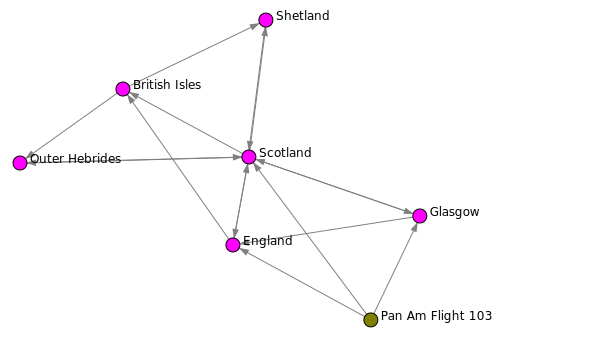

In [263]:
img

In [45]:
# Load data
with open('../informations_evaluation_new.pkl', 'rb') as data:
    info_eval_prob = pickle.load(data)

In [108]:
def display_inf_plot(values_dict, beta=5):
    
    rgb_values = sns.color_palette("colorblind", 8)
    
    datasets = ['wikivitals', 'wikivitals-fr', 'wikischools']
    markers = ['*', 'o', '^', '+', '1', '2']
    styles = ['solid', 'dotted', 'dashed', (0, (3, 10, 1, 10)), (5, (10, 3)), (5, (10, 3))]
    labels = ['summaries', 'louvain', 'gnn', 'spectral', 'doc2vec', 'Excess']
    subplot_names = ['left', 'centre', 'right']

    fig, axes = plt.subplot_mosaic(
        [["left", "top centre", "right"],
         ["left", "bottom centre", "right"]], figsize=(20, 5)
    )
    fig.subplots_adjust(hspace=0.1)

    for i, d in enumerate(datasets):
        vals = (np.asarray(list(info_eval_prob.get(d).get(beta).values())).ravel()) #np.max(values_dict.get(d).get(beta).get(labels[j])) + 0.3
        ymax = np.max(vals)
        sec_max = min(sorted(vals)[-5], 1)
        for j in range(len(labels)):
            if subplot_names[i] == 'centre':
                axes['top centre'].plot(values_dict.get(d).get(beta).get(labels[j]), marker=markers[j], linestyle=styles[j], markersize=8, color=rgb_values[j])
                axes['bottom centre'].plot(values_dict.get(d).get(beta).get(labels[j]), marker=markers[j], linestyle=styles[j], markersize=8, color=rgb_values[j])
                if beta == 5:
                    axes['top centre'].set_ylim(1.2, ymax + 0.5)  # outliers only
                    axes['bottom centre'].set_ylim(-0.02, 1.2)  # most of the data
                else:
                    axes['top centre'].set_ylim(sec_max + 0.5, ymax + 0.5)  # outliers only
                    axes['bottom centre'].set_ylim(-0.02, sec_max + 0.5)  # most of the data
                axes['top centre'].spines.bottom.set_visible(False)
                axes['bottom centre'].spines.top.set_visible(False)            
                axes['top centre'].get_xaxis().set_visible(False)
                axes['bottom centre'].set_xticks(np.arange(0, 4), labels=['8', '7', '6', '5'])
                #axes['top centre'].legend()
                axes['top centre'].set_title(rf"$\tt{d}$")
                axes['bottom centre'].set_xlabel(r'$s$')
            else:
                axes[subplot_names[i]].plot(values_dict.get(d).get(beta).get(labels[j]), marker=markers[j], linestyle=styles[j], markersize=8, color=rgb_values[j])
                axes[subplot_names[i]].set_xticks(np.arange(0, 4), labels=['8', '7', '6', '5'])
                #axes[subplot_names[i]].legend()
                axes[subplot_names[i]].set_title(rf"$\tt{d}$", fontsize=10)
                axes[subplot_names[i]].set_xlabel(r'$s$', fontsize=12)
            if i == 0:
                axes[subplot_names[i]].set_ylabel('Information', fontsize=12)

    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    axes['top centre'].plot([0, 1], [0, 0], transform=axes['top centre'].transAxes, **kwargs)
    axes['bottom centre'].plot([0, 1], [1, 1], transform=axes['bottom centre'].transAxes, **kwargs)

In [104]:
# Add values to dict
info_eval_prob.get('wikivitals').get(5)['Excess'] = information_excess_wikivitals
info_eval_prob.get('wikivitals-fr').get(5)['Excess'] = information_excess_wikivitals_fr
info_eval_prob.get('wikischools').get(5)['Excess'] = information_excess_wikischools

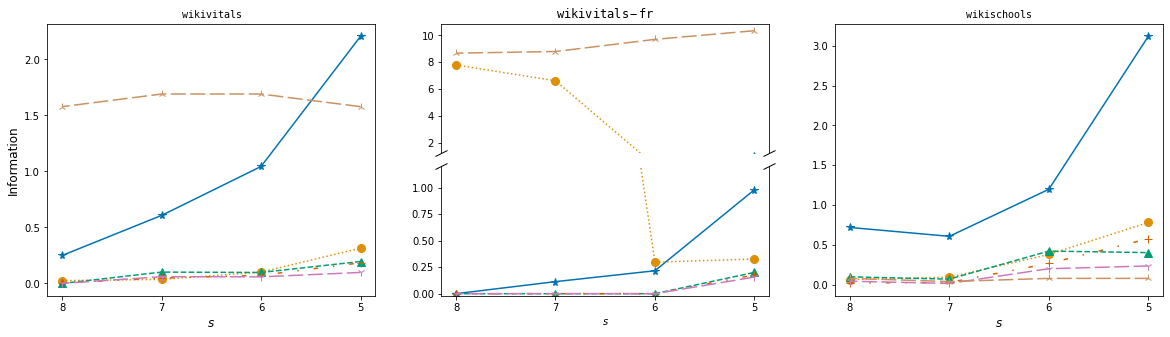

In [109]:
# For delta=0.0001, sigma=1 (puis filtre sur s), samplingTime=5000, SMinus=False
display_inf_plot(info_eval_prob, beta=5)

## Experiment 2  
---

- Chaque dataset est pré-filtré selon le paramètre $s$ (équivalent à ce qui est fait pour `UnexPatterns`)
- `Excess` est exécuté sur chaque dataset, avec les paramètres :
    - $\sigma = s$
    - `samplingTime=15000` $\rightarrow$ try to maximize number of patterns returned
    - $\delta=0.0001$ $\rightarrow$ borne très inférieure, cf papier p. 16-17
    - `activateSMinus=false` $\rightarrow$ JavaHeap Exception si true

In [293]:
import json
from collections import defaultdict

inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/experiments/Excess/results/'
ss = [8, 7, 6, 5]
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools']
informations_excess = defaultdict(list)

for d in datasets:
    print(f'****Dataset: {d}')

    # Load netset data
    adjacency, biadjacency, names, names_col, labels = load_data(d)
    
    model = load_gensim_model('models/', f'gensim_model_{d}')


    for s in ss:
        print(f'--s={s}')
        # Preprocess data (get same attribute order as in UnexPattern)
        new_biadjacency, words = preprocess_data(biadjacency, names_col, s, sort_data=False)
        print(f'Filtered biadjacency: {new_biadjacency.shape}')
        
        # Load patterns
        with open(f'{inpath}/{d}/retrievedPatterns_{s}.json', 'rb') as f:
            data = json.load(f)
            
        # List of all Excess patterns
        nb_excess_patterns = len(data.get('patterns'))

        # Load Excess patterns
        excess_patterns = [get_sias_pattern(data.get('patterns')[idx]) for idx in range(nb_excess_patterns)]
        excess_patterns_filt = [p for p in excess_patterns if len(p[0]) >= s]
    
        # Pattern x attributes matrix
        nb_excess_patterns_filt = len(excess_patterns_filt)
        print(f'Initial nb patterns: {nb_excess_patterns} - Number of Excess patterns with filter s={s}: {nb_excess_patterns_filt}')
        excess_patterns_attributes = np.zeros((nb_excess_patterns_filt, new_biadjacency.shape[1]))
        for i, p in enumerate(excess_patterns_filt):
            excess_patterns_attributes[i, p[1]] = 1

        # Wasserstein distances
        inpath_w = f'/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/output/result'
        w_filename = f'wasserstein_distances_{d}_5_{s}_excess_patterns.pkl'
        with open(f'{inpath_w}/{w_filename}', 'rb') as data:
            d2v_wd_matrix_excess = np.load(data)
        

        # Information
        div = diversity(d2v_wd_matrix_excess, delta=0.2)
        cov = coverage_excess(excess_patterns_filt, adjacency.shape[0])
        conc = conciseness_excess(excess_patterns_filt)
        information = (div * cov) / np.sqrt(conc)

        informations_excess[d].append(information * 100)

****Dataset: wikivitals
Parsing files...
Done.
Training gensim model...
--s=8
Filtered biadjacency: (10011, 13170)
Initial nb patterns: 8 - Number of Excess patterns with filter s=8: 8


100%|██████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.19it/s]


--s=7
Filtered biadjacency: (10011, 14480)
Initial nb patterns: 11 - Number of Excess patterns with filter s=7: 11


100%|████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.50it/s]


--s=6
Filtered biadjacency: (10011, 16090)
Initial nb patterns: 13 - Number of Excess patterns with filter s=6: 13


100%|████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 26.61it/s]


--s=5
Filtered biadjacency: (10011, 18338)
Initial nb patterns: 1 - Number of Excess patterns with filter s=5: 1


100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 160.39it/s]


****Dataset: wikivitals-fr
Parsing files...
Done.
Training gensim model...
--s=8
Filtered biadjacency: (9945, 9259)
Initial nb patterns: 928 - Number of Excess patterns with filter s=8: 908


100%|██████████████████████████████████████████████████████████████████████| 908/908 [38:41<00:00,  2.56s/it]


--s=7
Filtered biadjacency: (9945, 10181)
Initial nb patterns: 1227 - Number of Excess patterns with filter s=7: 1210


100%|██████████████████████████████████████████████████████████████████| 1210/1210 [1:11:08<00:00,  3.53s/it]


--s=6
Filtered biadjacency: (9945, 11406)
Initial nb patterns: 665 - Number of Excess patterns with filter s=6: 662


100%|██████████████████████████████████████████████████████████████████████| 662/662 [20:38<00:00,  1.87s/it]


--s=5
Filtered biadjacency: (9945, 13138)
Initial nb patterns: 475 - Number of Excess patterns with filter s=5: 466


100%|██████████████████████████████████████████████████████████████████████| 466/466 [10:35<00:00,  1.36s/it]


****Dataset: wikischools
Parsing files...
Done.
Training gensim model...
--s=8
Filtered biadjacency: (4403, 6550)
Initial nb patterns: 5156 - Number of Excess patterns with filter s=8: 4999


100%|█████████████████████████████████████████████████████████████████| 4999/4999 [20:33:08<00:00, 14.80s/it]


--s=7
Filtered biadjacency: (4403, 7120)
Initial nb patterns: 5284 - Number of Excess patterns with filter s=7: 5085


100%|█████████████████████████████████████████████████████████████████| 5085/5085 [21:39:10<00:00, 15.33s/it]


--s=6
Filtered biadjacency: (4403, 7859)
Initial nb patterns: 5082 - Number of Excess patterns with filter s=6: 4917


100%|█████████████████████████████████████████████████████████████████| 4917/4917 [19:54:31<00:00, 14.58s/it]


--s=5
Filtered biadjacency: (4403, 8942)
Initial nb patterns: 7679 - Number of Excess patterns with filter s=5: 7293


100%|█████████████████████████████████████████████████████████████████| 7293/7293 [52:21:48<00:00, 25.85s/it]


In [294]:
# Save data
with open(f'{inpath}/informations_excess_all.pkl', 'wb') as f:
    pickle.dump(informations_excess, f)

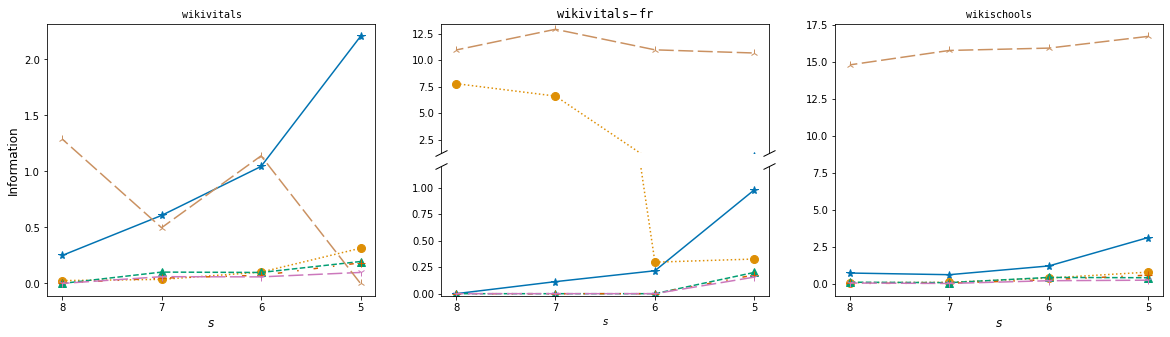

In [300]:
second_dict = info_eval_prob.copy()
second_dict.get('wikivitals').get(5)['Excess'] = informations_excess.get('wikivitals')
second_dict.get('wikivitals-fr').get(5)['Excess'] = informations_excess.get('wikivitals-fr')
second_dict.get('wikischools').get(5)['Excess'] = informations_excess.get('wikischools')

display_inf_plot(second_dict, beta=5)

*Width modified*

In [692]:
import gensim
from gensim.models import Doc2Vec

def get_excess_pattern(pattern: dict, names, names_col):
    
    # get subgraph
    try:
        subgraph_nodes = np.asarray([np.where(names == x)[0][0] for x in pattern.get('subgraph') if '?' not in x])
    except IndexError:
        print(pattern.get('subgraph'))
    
    # get attributes
    pos_attrs = set(pattern.get('characteristic').get('positiveAttributes'))
    neg_attrs = set(pattern.get('characteristic').get('negativeAttributes'))
    attrs = np.asarray([np.where(names_col == x)[0][0] for x in pos_attrs.union(neg_attrs)])
    
    return subgraph_nodes, attrs

def load_gensim_model(inpath, name):
    model = Doc2Vec.load(f'{inpath}/{name}.model')
    return model

def conciseness_excess(adjacency, biadjacency, nb_cc, patterns_excess) -> float:
    """Conciseness of summarized graph, i.e. sum of the median of number of nodes and median of number of attributes per pattern/community.
    
    Outputs
    -------
        Conciseness. 
    """
    extent_size_summaries, intent_size_summaries = [], []
    for i in patterns_excess:
        extent_size_summaries.append(len(i[0]))
        intent_size_summaries.append(len(i[1]))

    avg_deg = np.mean(get_degrees(adjacency.astype(bool)))
    avg_deg_attr = np.mean(get_degrees(biadjacency.astype(bool)))

    #return nb_cc * ((np.mean(extent_size_summaries) / avg_deg) * (np.mean(intent_size_summaries) / avg_deg_attr))
    print(f'# patterns: {nb_cc}')
    return nb_cc * np.sqrt(np.mean(extent_size_summaries) * np.mean(intent_size_summaries))

### Excess information

In [693]:
import os
import json
from collections import defaultdict

inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/experiments/Excess/results'
ss = [8, 7, 6, 5]
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools', 'sanFranciscoCrimes']
informations_excess = defaultdict(list)

for d in datasets:
    print(f'****Dataset: {d}')

    # Load netset data
    adjacency, biadjacency, names, names_col, labels = load_data(d)
    
    model = load_gensim_model('../models/', f'gensim_model_{d}')

    for s in ss:
        print(f'--s={s}')
        # Preprocess data (get same attribute order as in UnexPattern)
        new_biadjacency, words = preprocess_data(biadjacency, names_col, s, sort_data=False)
        print(f'Filtered biadjacency: {new_biadjacency.shape}')
        
        # Load patterns
        with open(f'{inpath}/{d}/retrievedPatterns_{s}.json', 'rb') as f:
            data = json.load(f)
            
        # List of all Excess patterns
        nb_excess_patterns = len(data.get('patterns'))

        # Load Excess patterns
        if d != 'sanFranciscoCrimes':
            excess_patterns = [get_sias_pattern(data.get('patterns')[idx]) for idx in range(nb_excess_patterns)]
            excess_patterns_filt = [p for p in excess_patterns if len(p[0]) >= s]
        else:
            excess_patterns = [get_excess_pattern(data.get('patterns')[idx], names, names_col) for idx in range(nb_excess_patterns)]
            excess_patterns_filt = [p for p in excess_patterns if len(p[0]) >= s]
    
        # Pattern x attributes matrix
        nb_excess_patterns_filt = len(excess_patterns_filt)
        print(f'Initial nb patterns: {nb_excess_patterns} - Number of Excess patterns with filter s={s}: {nb_excess_patterns_filt}')
        if d != 'sanFranciscoCrimes':
            excess_patterns_attributes = np.zeros((nb_excess_patterns_filt, new_biadjacency.shape[1]))
        else:
            excess_patterns_attributes = np.zeros((nb_excess_patterns_filt, biadjacency.shape[1]))
        for i, p in enumerate(excess_patterns_filt):
            excess_patterns_attributes[i, p[1]] = 1

        # Wasserstein distances
        inpath_w = f'/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/output/result'
        w_filename = f'wasserstein_distances_{d}_5_{s}_excess_patterns.pkl'
        if os.path.exists(f'{inpath_w}/{w_filename}'):
            with open(f'{inpath_w}/{w_filename}', 'rb') as data:
                d2v_wd_matrix_excess = np.load(data)
        else:
            d2v_wd_matrix = pairwise_wd_distance(excess_patterns_attributes, nb_excess_patterns_filt, model, names_col)
            # Save distances
            with open(f'{inpath_w}/{w_filename}', 'wb') as f:
                np.save(f, d2v_wd_matrix)

        # Information
        div = diversity(d2v_wd_matrix_excess, delta=0.2)
        cov = coverage_excess(excess_patterns_filt, adjacency.shape[0])
        #conc = conciseness_excess(excess_patterns_filt)
        conc = conciseness_excess(adjacency, biadjacency, nb_excess_patterns, excess_patterns)
        information = (div * cov) / conc
        informations_excess[d].append(information)
        
        with open(f'{inpath_w}/information_details_{d}_5_{s}_excess.txt', 'w') as f:
            f.write(f'{div}, {cov}, {conc}, {information}')
        print(f'{div}, {cov}, {conc}, {information}')

****Dataset: wikivitals
Parsing files...
Done.
--s=8
Filtered biadjacency: (10011, 13170)
Initial nb patterns: 8 - Number of Excess patterns with filter s=8: 8
# patterns: 8
0.7222222222222222, 0.16891419438617522, 166.80827317612278, 0.0007313401338652683
--s=7
Filtered biadjacency: (10011, 14480)
Initial nb patterns: 11 - Number of Excess patterns with filter s=7: 11
# patterns: 11
0.2878787878787879, 0.4200379582459295, 277.8848682458259, 0.0004351443065116787
--s=6
Filtered biadjacency: (10011, 16090)
Initial nb patterns: 13 - Number of Excess patterns with filter s=6: 13
# patterns: 13
0.5714285714285714, 0.3492158625511937, 289.09168095951844, 0.0006902720991330369
--s=5
Filtered biadjacency: (10011, 18338)
Initial nb patterns: 1 - Number of Excess patterns with filter s=5: 1
# patterns: 1
0.0, 0.016381979822195584, 12.806248474865697, 0.0
****Dataset: wikivitals-fr
Parsing files...
Done.
--s=8
Filtered biadjacency: (9945, 9259)
Initial nb patterns: 928 - Number of Excess pattern

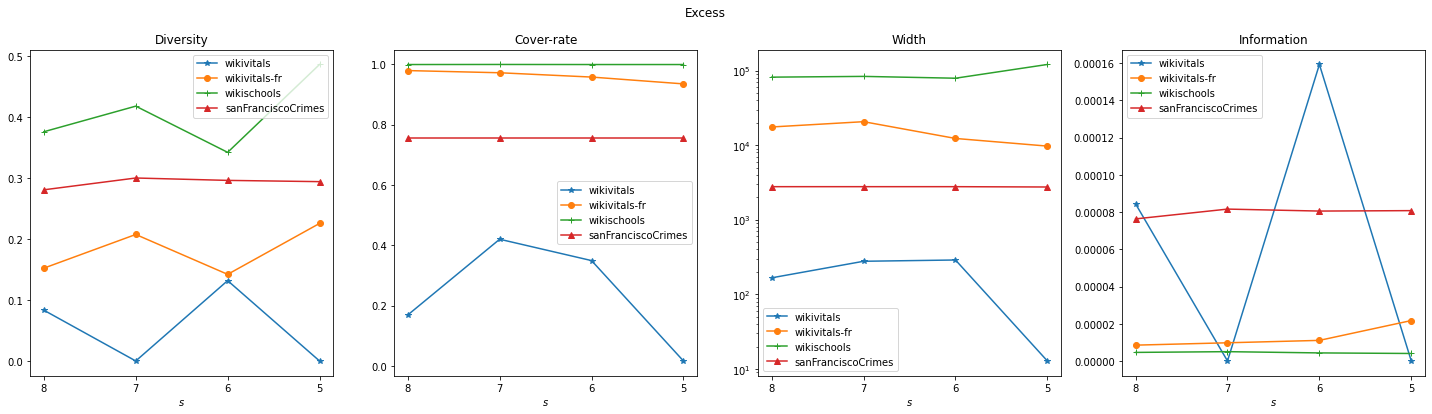

In [796]:
# Load data
expath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/experiments/Excess/results'

titles = ['Diversity', 'Cover-rate', 'Width', 'Information', 'Information modif']
markers = ['*', 'o', '+', '^']
ss = [8, 7, 6, 5]

diversities, cover_rates, concisenesses, all_inf = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)

fig, ax = plt.subplots(1, 4, figsize=(25, 6))
plt.suptitle('Excess')

for i, d in enumerate(['wikivitals', 'wikivitals-fr', 'wikischools', 'sanFranciscoCrimes']):
    if d=='sanFranciscoCrimes':
        gamma = 0.2
    else:
        gamma = 0.8
    for s in ss:
        with open(f'{expath}/{d}/information_details_{d}_5_{s}_{gamma}_excess.txt', 'r') as data:
            info_excess_raw = data.readlines()
        vals = list(map(float, info_excess_raw[0].split(', ')))
        diversities[d].append(vals[0])
        cover_rates[d].append(vals[1])
        concisenesses[d].append(vals[2])
        all_inf[d].append(vals[3])
        
    ax[0].plot(np.arange(0, 4), diversities[d], label=d, marker=markers[i])
    ax[1].plot(np.arange(0, 4), cover_rates[d], label=d, marker=markers[i])
    ax[2].plot(np.arange(0, 4), concisenesses[d], label=d, marker=markers[i])
    ax[3].plot(np.arange(0, 4), all_inf[d], label=d, marker=markers[i])
    
for i in range(4):
    ax[i].set_xticks(np.arange(0, 4), ss)
    ax[i].legend()
    ax[i].set_title(titles[i])
    ax[i].set_xlabel(r'$s$')
    if i == 2:
        ax[i].set_yscale('log')

In [788]:
def clip(val):
    if val == 0:
        return 1e-8
    else:
        return val

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


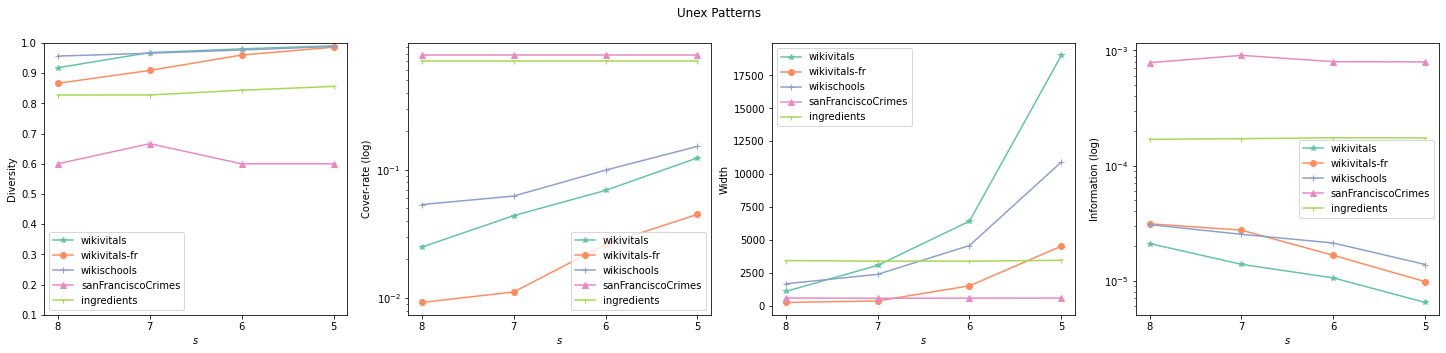

In [875]:
# Load data
inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/output/result/with_prob/new'

titles = ['Diversity', 'Cover-rate', 'Width', 'Information', 'Information modif']
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools', 'sanFranciscoCrimes', 'ingredients']
markers = ['*', 'o', '+', '^', '1']

ss = [8, 7, 6, 5]

diversities, cover_rates, concisenesses, all_inf = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)

fig, ax = plt.subplots(1, 4, figsize=(25, 5))

plt.suptitle('Unex Patterns')
for i, d in enumerate(datasets):
    if d=='sanFranciscoCrimes':
        gamma = 0.2
    elif d=='ingredients':
        gamma = 0.05
    else:
        gamma = 0.8
        
    if d=='ingredients':
        b = 1
    else:
        b = 4
        
    for s in ss:
        with open(f'{inpath}/information_details_{d}_{b}_{s}_summaries_{gamma}_new_conc.txt', 'r') as data:
            info_summaries = data.readlines()
        vals = list(map(float, info_summaries[0].split(', ')))
        diversities[d].append(vals[0])
        cover_rates[d].append(vals[1])
        concisenesses[d].append(vals[2])
        all_inf[d].append(vals[3])
        
    ax[0].plot(np.arange(0, 4), diversities[d], label=d, marker=markers[i], color=plt.cm.Set2(i))
    ax[1].plot(np.arange(0, 4), cover_rates[d], label=d, marker=markers[i], color=plt.cm.Set2(i))
    ax[2].plot(np.arange(0, 4), concisenesses[d], label=d, marker=markers[i], color=plt.cm.Set2(i))
    ax[3].plot(np.arange(0, 4), all_inf[d], label=d, marker=markers[i], color=plt.cm.Set2(i))
    
for i in range(4):
    ax[i].set_xticks(np.arange(0, 4), ss)
    ax[i].legend()
    #ax[i].set_title(titles[i])
    
    ax[i].set_xlabel(r'$s$')
    if i==3 or i==1:
        ax[i].set_yscale('log')
        ax[i].set_ylabel(titles[i] + ' (log)')
    else:
        ax[i].set_ylabel(titles[i])
    if i==0:
        ax[i].set_ylim(0.1, 1)
        
plt.savefig(f'../output/img/information_unexpatterns_all_datasets.eps', dpi=800, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


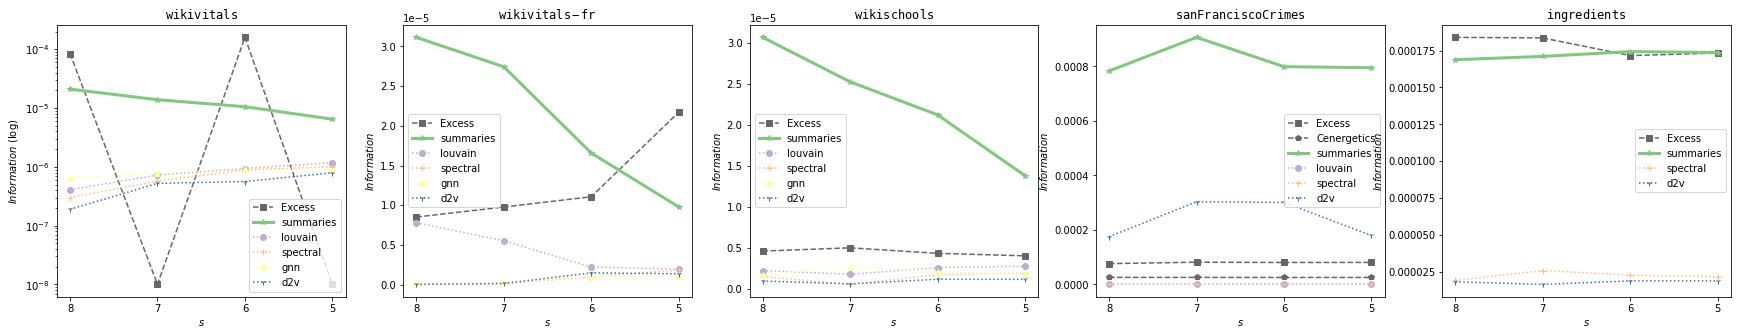

In [877]:
fig, ax = plt.subplots(1, 5, figsize=(30, 5))

all_inf = defaultdict(list)
inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/output/result'
expath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/experiments'
methods = ['summaries', 'louvain', 'spectral', 'gnn', 'd2v']
#colors = ['blue', 'orange', 'red', 'green', 'black', 'yellow', 'brown']
colors = [plt.cm.Accent(x) for x in range(10)]
markers = ['*', 'o', '+', '^', '1', '2', 's', 'p']


for i, d in enumerate(['wikivitals', 'wikivitals-fr', 'wikischools', 'sanFranciscoCrimes', 'ingredients']):
    all_inf[d] = defaultdict(list)
    if d == 'sanFranciscoCrimes':
        gamma = 0.2
    elif d == 'ingredients':
        gamma = 0.05
    else:
        gamma = 0.8
        
    if d == 'ingredients':
        beta = 1
    else:
        beta = 4
        
    for s in ss:        
        # Excess results
        with open(f'{expath}/Excess/results/{d}/information_details_{d}_5_{s}_{gamma}_excess.txt', 'r') as data:
            info_excess_raw = data.readlines()
        vals = list(map(float, info_excess_raw[0].split(', ')))
        all_inf[d]['excess'].append(clip(vals[3]))
        
        # Cenergetics results
        if d == 'sanFranciscoCrimes':
            with open(f'{expath}/Cenergetics/results/{d}/information_details_{d}_5_{s}_{gamma}_cenergetics.txt', 'r') as data:
                info_cenergetics_raw = data.readlines()
            vals = list(map(float, info_cenergetics_raw[0].split(', ')))
            all_inf[d]['cenergetics'].append(clip(vals[3]))
        
        # Unex patterns + baselines
        for m in methods:
            if m in ['gnn', 'louvain'] and d == 'ingredients':
                pass
            elif not (m == 'gnn' and d=='sanFranciscoCrimes'):
                with open(f'{inpath}/with_prob/new/information_details_{d}_{beta}_{s}_{m}_{gamma}_new_conc.txt', 'r') as data:
                    info = data.readlines()
                vals = list(map(float, info[0].split(', ')))
                all_inf[d][m].append(clip(vals[3]))

    ax[i].plot(np.arange(0, 4), all_inf[d]['excess'], label='Excess', color=colors[-2], marker=markers[-2], linestyle='dashed')
    if d == 'sanFranciscoCrimes':
        ax[i].plot(np.arange(0, 4), all_inf[d]['cenergetics'], label='Cenergetics', color=colors[-1], marker=markers[-1], linestyle='dashed')
    for j, m in enumerate(methods):
        if m in ['gnn', 'louvain'] and d == 'ingredients':
            pass
        elif not (m == 'gnn' and d=='sanFranciscoCrimes'):
            if m == 'summaries':
                ax[i].plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linewidth=3)
            else:
                ax[i].plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linestyle='dotted')
    ax[i].set_title(rf'$\tt{d}$')
    ax[i].set_xticks(np.arange(0, 4), ss)
    ax[i].legend()
    ax[i].set_xlabel(r'$s$')
    if i==0 :#or i==4:
        ax[i].set_yscale('log')
        ax[i].set_ylabel(rf'$Information$ (log)')
    else:
        ax[i].set_ylabel(rf'$Information$')
        
# Save image
plt.savefig('../output/img/information_evaluation_all_datasets.eps', dpi=800, bbox_inches='tight')

**Correction on number of nodes in pattern summaries**

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


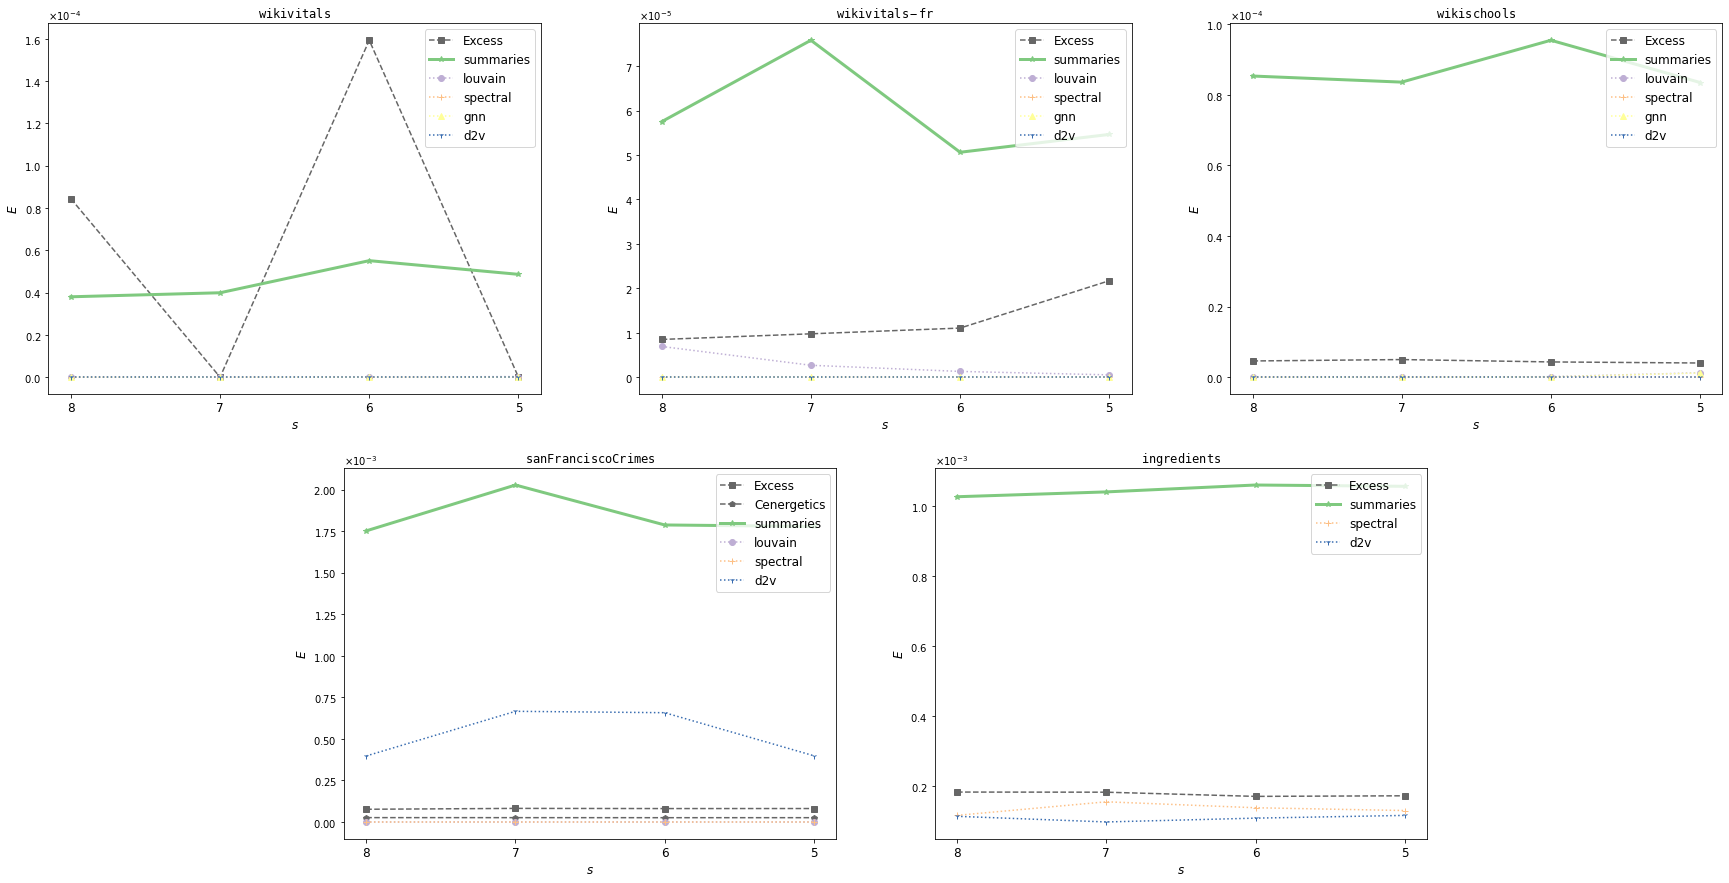

In [1511]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(30, 15)) 
gs = gridspec.GridSpec(2, 6)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:4])
ax3 = plt.subplot(gs[0, 4:])
ax4 = plt.subplot(gs[1, 1:3])
ax5 = plt.subplot(gs[1, 3:5])

all_inf = defaultdict(list)
all_inf_old = defaultdict(list)
inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/output/result'
expath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/experiments'
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools', 'sanFranciscoCrimes', 'ingredients']
methods = ['summaries', 'louvain', 'spectral', 'gnn', 'd2v']
#colors = ['blue', 'orange', 'red', 'green', 'black', 'yellow', 'brown']
colors = [plt.cm.Accent(x) for x in range(10)]
markers = ['*', 'o', '+', '^', '1', '2', 's', 'p']

for i, d in enumerate(datasets):
    all_inf[d] = defaultdict(list)
    all_inf_old[d] = defaultdict(list)
    if d == 'sanFranciscoCrimes':
        gamma = 0.2
    elif d == 'ingredients':
        gamma = 0.05
    else:
        gamma = 0.8
        
    if d == 'ingredients':
        beta = 1
    else:
        beta = 4
        
    for s in ss:        
        # Excess results
        with open(f'{expath}/Excess/results/{d}/information_details_{d}_5_{s}_{gamma}_excess.txt', 'r') as data:
            info_excess_raw = data.readlines()
        vals = list(map(float, info_excess_raw[0].split(', ')))
        all_inf[d]['excess'].append(clip(vals[3]))
        
        # Cenergetics results
        if d == 'sanFranciscoCrimes':
            with open(f'{expath}/Cenergetics/results/{d}/information_details_{d}_5_{s}_{gamma}_cenergetics.txt', 'r') as data:
                info_cenergetics_raw = data.readlines()
            vals = list(map(float, info_cenergetics_raw[0].split(', ')))
            all_inf[d]['cenergetics'].append(clip(vals[3]))
        
        # Unex patterns + baselines
        for m in methods:
            if m in ['gnn', 'louvain'] and d == 'ingredients':
                pass
            elif not (m == 'gnn' and d=='sanFranciscoCrimes'):
                with open(f'{inpath}/with_prob/new/information_details_{d}_{beta}_{s}_{m}_{gamma}_new_conc_new.txt', 'r') as data: # Here is the modification
                    info = data.readlines()
                vals = list(map(float, info[0].split(', ')))
                all_inf[d][m].append(clip(vals[3]))
                
                with open(f'{inpath}/with_prob/new/information_details_{d}_{beta}_{s}_{m}_{gamma}_new_conc.txt', 'r') as data: # Here is the modification
                    info = data.readlines()
                vals = list(map(float, info[0].split(', ')))
                all_inf_old[d][m].append(clip(vals[3]))

    if d in ['sanFranciscoCrimes']:
        ax4.plot(np.arange(0, 4), all_inf[d]['excess'], label='Excess', color=colors[-2], marker=markers[-2], linestyle='dashed')
        ax4.plot(np.arange(0, 4), all_inf[d]['cenergetics'], label='Cenergetics', color=colors[-1], marker=markers[-1], linestyle='dashed')
    elif d in ['ingredients']:
        ax5.plot(np.arange(0, 4), all_inf[d]['excess'], label='Excess', color=colors[-2], marker=markers[-2], linestyle='dashed')
    elif d == 'wikivitals':
        ax1.plot(np.arange(0, 4), all_inf[d]['excess'], label='Excess', color=colors[-2], marker=markers[-2], linestyle='dashed')
    elif d == 'wikivitals-fr':
        ax2.plot(np.arange(0, 4), all_inf[d]['excess'], label='Excess', color=colors[-2], marker=markers[-2], linestyle='dashed')
    elif d == 'wikischools':
        ax3.plot(np.arange(0, 4), all_inf[d]['excess'], label='Excess', color=colors[-2], marker=markers[-2], linestyle='dashed')
    
    for j, m in enumerate(methods):
        if m in ['gnn', 'louvain'] and d == 'ingredients':
            pass
        elif not (m == 'gnn' and d=='sanFranciscoCrimes'):
            if m == 'summaries':
                if d in ['sanFranciscoCrimes']:
                    ax4.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linewidth=3)
                elif d in ['ingredients']:
                    ax5.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linewidth=3)
                elif d == 'wikivitals':
                    ax1.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linewidth=3)
                elif d == 'wikivitals-fr':
                    ax2.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linewidth=3)
                elif d == 'wikischools':
                    ax3.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linewidth=3)
                #ax[i].plot(np.arange(0, 4), all_inf_old[d][m], label='summaries old', marker=markers[j], color='lightgreen', linewidth=3)
            else:
                if d in ['sanFranciscoCrimes']:
                    ax4.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linestyle='dotted')
                elif d in ['ingredients']:
                    ax5.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linestyle='dotted')
                elif d == 'wikivitals':
                    ax1.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linestyle='dotted')
                elif d == 'wikivitals-fr':
                    ax2.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linestyle='dotted')
                elif d == 'wikischools':
                    ax3.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linestyle='dotted')
axes = [ax1, ax2, ax3, ax4, ax5]
for i, ax in enumerate(axes):
    ax.legend(loc='upper right', fontsize=12);
    ax.set_xticks(np.arange(0, 4), ss, fontsize=12)
    ax.set_xlabel(r'$s$', fontsize=12)
    ax.set_ylabel(rf'$E$', fontsize=12)
    ax.yaxis.set_major_formatter(formatter) 
    ax.set_title(rf'$\tt{datasets[i]}$', fontsize=12)
    
# Save image
plt.savefig('../output/img/expressiveness_evaluation_all_datasets.eps', dpi=800, bbox_inches='tight')

**New run**

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


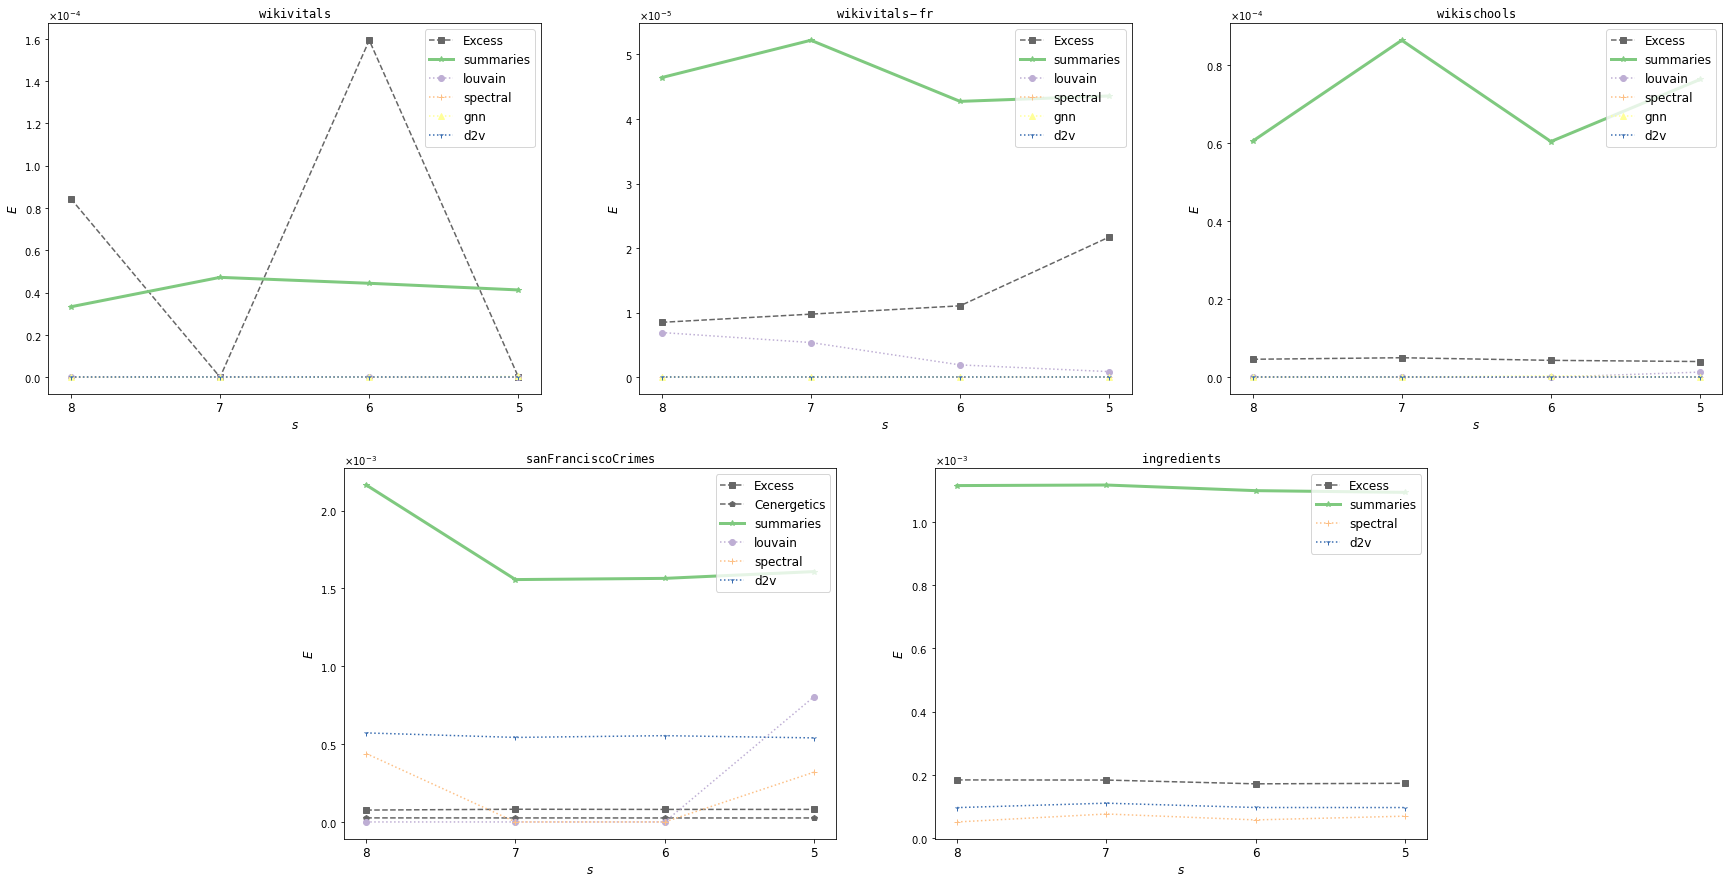

In [1531]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(30, 15)) 
gs = gridspec.GridSpec(2, 6)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:4])
ax3 = plt.subplot(gs[0, 4:])
ax4 = plt.subplot(gs[1, 1:3])
ax5 = plt.subplot(gs[1, 3:5])

all_inf = defaultdict(list)
inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/output/result'
expath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/experiments'
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools', 'sanFranciscoCrimes', 'ingredients']
methods = ['summaries', 'louvain', 'spectral', 'gnn', 'd2v']
#colors = ['blue', 'orange', 'red', 'green', 'black', 'yellow', 'brown']
colors = [plt.cm.Accent(x) for x in range(10)]
markers = ['*', 'o', '+', '^', '1', '2', 's', 'p']

for i, d in enumerate(datasets):
    all_inf[d] = defaultdict(list)
    if d == 'sanFranciscoCrimes':
        gamma = 0.2
    elif d == 'ingredients':
        gamma = 0.05
    else:
        gamma = 0.8
        
    if d == 'ingredients':
        beta = 1
    else:
        beta = 4
        
    for s in ss:        
        # Excess results
        with open(f'{expath}/Excess/results/{d}/information_details_{d}_5_{s}_{gamma}_excess.txt', 'r') as data:
            info_excess_raw = data.readlines()
        vals = list(map(float, info_excess_raw[0].split(', ')))
        all_inf[d]['excess'].append(clip(vals[3]))
        
        # Cenergetics results
        if d == 'sanFranciscoCrimes':
            with open(f'{expath}/Cenergetics/results/{d}/information_details_{d}_5_{s}_{gamma}_cenergetics.txt', 'r') as data:
                info_cenergetics_raw = data.readlines()
            vals = list(map(float, info_cenergetics_raw[0].split(', ')))
            all_inf[d]['cenergetics'].append(clip(vals[3]))
        
        # Unex patterns + baselines
        for m in methods:
            if m in ['gnn', 'louvain'] and d == 'ingredients':
                pass
            elif not (m == 'gnn' and d=='sanFranciscoCrimes'):
                with open(f'{inpath}/with_prob/final/information_details_{d}_{beta}_{s}_{m}_{gamma}_new_conc_new2.txt', 'r') as data: # Here is the modification
                    info = data.readlines()
                vals = list(map(float, info[0].split(', ')))
                all_inf[d][m].append(clip(vals[3]))

    if d in ['sanFranciscoCrimes']:
        ax4.plot(np.arange(0, 4), all_inf[d]['excess'], label='Excess', color=colors[-2], marker=markers[-2], linestyle='dashed')
        ax4.plot(np.arange(0, 4), all_inf[d]['cenergetics'], label='Cenergetics', color=colors[-1], marker=markers[-1], linestyle='dashed')
    elif d in ['ingredients']:
        ax5.plot(np.arange(0, 4), all_inf[d]['excess'], label='Excess', color=colors[-2], marker=markers[-2], linestyle='dashed')
    elif d == 'wikivitals':
        ax1.plot(np.arange(0, 4), all_inf[d]['excess'], label='Excess', color=colors[-2], marker=markers[-2], linestyle='dashed')
    elif d == 'wikivitals-fr':
        ax2.plot(np.arange(0, 4), all_inf[d]['excess'], label='Excess', color=colors[-2], marker=markers[-2], linestyle='dashed')
    elif d == 'wikischools':
        ax3.plot(np.arange(0, 4), all_inf[d]['excess'], label='Excess', color=colors[-2], marker=markers[-2], linestyle='dashed')
    
    for j, m in enumerate(methods):
        if m in ['gnn', 'louvain'] and d == 'ingredients':
            pass
        elif not (m == 'gnn' and d=='sanFranciscoCrimes'):
            if m == 'summaries':
                if d in ['sanFranciscoCrimes']:
                    ax4.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linewidth=3)
                elif d in ['ingredients']:
                    ax5.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linewidth=3)
                elif d == 'wikivitals':
                    ax1.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linewidth=3)
                elif d == 'wikivitals-fr':
                    ax2.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linewidth=3)
                elif d == 'wikischools':
                    ax3.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linewidth=3)
            else:
                if d in ['sanFranciscoCrimes']:
                    ax4.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linestyle='dotted')
                elif d in ['ingredients']:
                    ax5.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linestyle='dotted')
                elif d == 'wikivitals':
                    ax1.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linestyle='dotted')
                elif d == 'wikivitals-fr':
                    ax2.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linestyle='dotted')
                elif d == 'wikischools':
                    ax3.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linestyle='dotted')
axes = [ax1, ax2, ax3, ax4, ax5]
for i, ax in enumerate(axes):
    ax.legend(loc='upper right', fontsize=12);
    ax.set_xticks(np.arange(0, 4), ss, fontsize=12)
    ax.set_xlabel(r'$s$', fontsize=12)
    ax.set_ylabel(rf'$E$', fontsize=12)
    ax.yaxis.set_major_formatter(formatter) 
    ax.set_title(rf'$\tt{datasets[i]}$', fontsize=12)
    
# Save image
plt.savefig('../output/img/expressiveness_evaluation_all_datasets_final.eps', dpi=800, bbox_inches='tight')

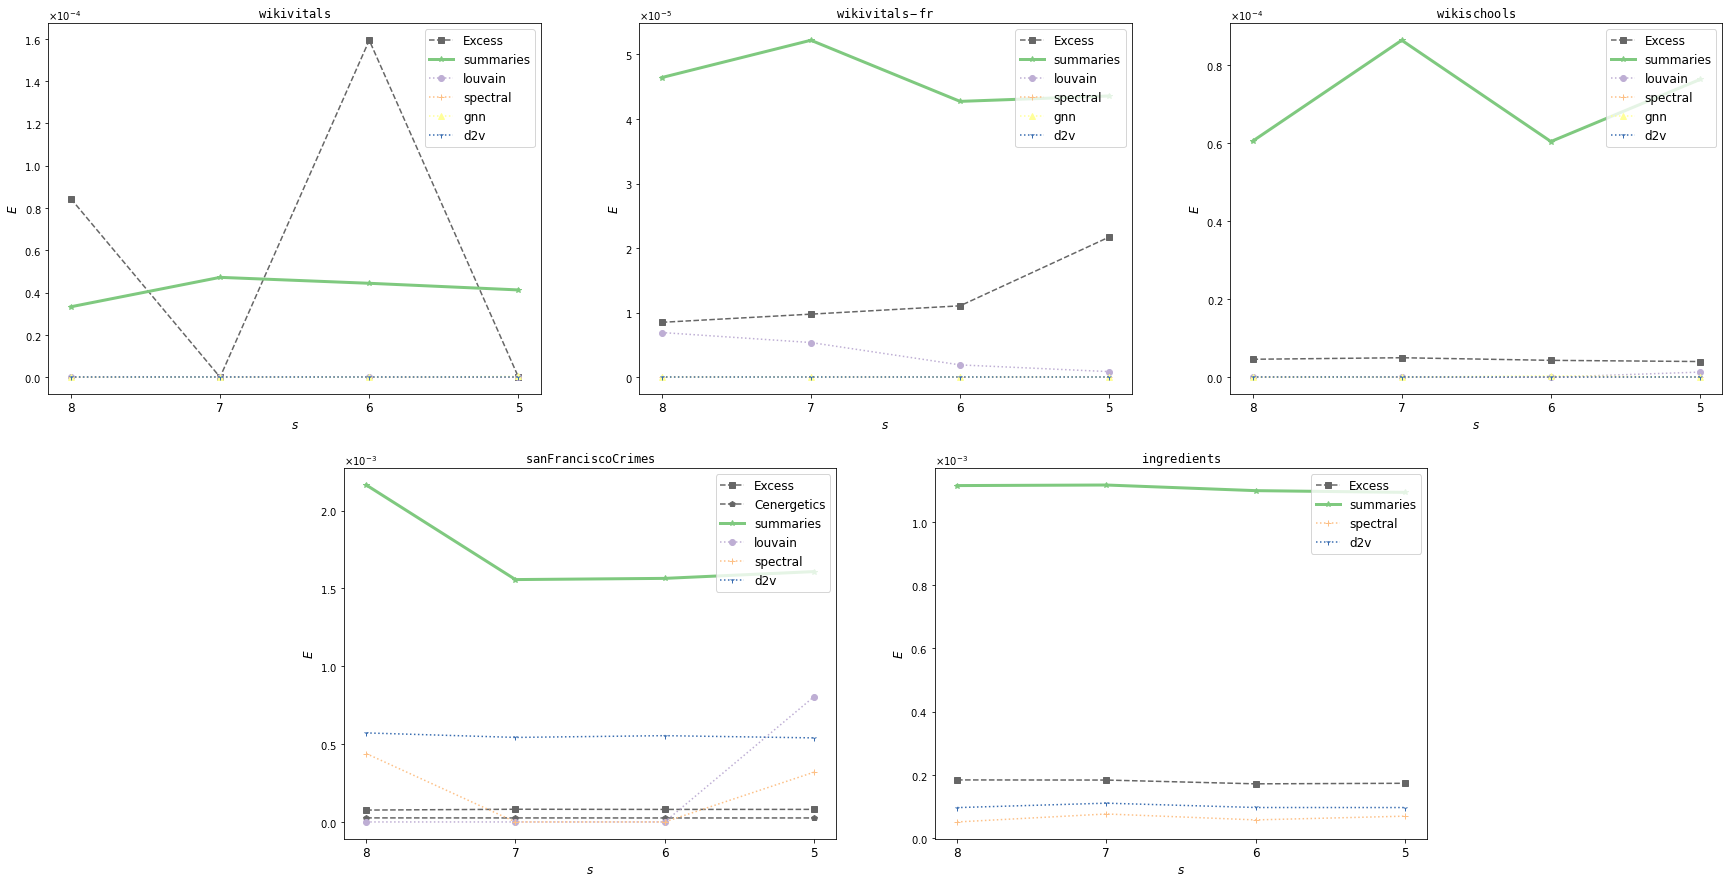

In [1532]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(30, 15)) 
gs = gridspec.GridSpec(2, 6)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:4])
ax3 = plt.subplot(gs[0, 4:])
ax4 = plt.subplot(gs[1, 1:3])
ax5 = plt.subplot(gs[1, 3:5])

all_inf = defaultdict(list)
inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/output/result'
expath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/experiments'
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools', 'sanFranciscoCrimes', 'ingredients']
methods = ['summaries', 'louvain', 'spectral', 'gnn', 'd2v']
#colors = ['blue', 'orange', 'red', 'green', 'black', 'yellow', 'brown']
colors = [plt.cm.Accent(x) for x in range(10)]
markers = ['*', 'o', '+', '^', '1', '2', 's', 'p']

for i, d in enumerate(datasets):
    all_inf[d] = defaultdict(list)
    if d == 'sanFranciscoCrimes':
        gamma = 0.2
    elif d == 'ingredients':
        gamma = 0.05
    else:
        gamma = 0.8
        
    if d == 'ingredients':
        beta = 1
    else:
        beta = 4
        
    for s in ss:        
        # Excess results
        with open(f'{expath}/Excess/results/{d}/information_details_{d}_5_{s}_{gamma}_excess.txt', 'r') as data:
            info_excess_raw = data.readlines()
        vals = list(map(float, info_excess_raw[0].split(', ')))
        all_inf[d]['excess'].append(clip(vals[3]))
        
        # Cenergetics results
        if d == 'sanFranciscoCrimes':
            with open(f'{expath}/Cenergetics/results/{d}/information_details_{d}_5_{s}_{gamma}_cenergetics.txt', 'r') as data:
                info_cenergetics_raw = data.readlines()
            vals = list(map(float, info_cenergetics_raw[0].split(', ')))
            all_inf[d]['cenergetics'].append(clip(vals[3]))
        
        # Unex patterns + baselines
        for m in methods:
            if m in ['gnn', 'louvain'] and d == 'ingredients':
                pass
            elif not (m == 'gnn' and d=='sanFranciscoCrimes'):
                with open(f'{inpath}/with_prob/final/information_details_{d}_{beta}_{s}_{m}_{gamma}_new_conc_new2.txt', 'r') as data: # Here is the modification
                    info = data.readlines()
                vals = list(map(float, info[0].split(', ')))
                all_inf[d][m].append(clip(vals[3]))

    if d in ['sanFranciscoCrimes']:
        ax4.plot(np.arange(0, 4), all_inf[d]['excess'], label='Excess', color=colors[-2], marker=markers[-2], linestyle='dashed')
        ax4.plot(np.arange(0, 4), all_inf[d]['cenergetics'], label='Cenergetics', color=colors[-1], marker=markers[-1], linestyle='dashed')
    elif d in ['ingredients']:
        ax5.plot(np.arange(0, 4), all_inf[d]['excess'], label='Excess', color=colors[-2], marker=markers[-2], linestyle='dashed')
    elif d == 'wikivitals':
        ax1.plot(np.arange(0, 4), all_inf[d]['excess'], label='Excess', color=colors[-2], marker=markers[-2], linestyle='dashed')
    elif d == 'wikivitals-fr':
        ax2.plot(np.arange(0, 4), all_inf[d]['excess'], label='Excess', color=colors[-2], marker=markers[-2], linestyle='dashed')
    elif d == 'wikischools':
        ax3.plot(np.arange(0, 4), all_inf[d]['excess'], label='Excess', color=colors[-2], marker=markers[-2], linestyle='dashed')
    
    for j, m in enumerate(methods):
        if m in ['gnn', 'louvain'] and d == 'ingredients':
            pass
        elif not (m == 'gnn' and d=='sanFranciscoCrimes'):
            if m == 'summaries':
                if d in ['sanFranciscoCrimes']:
                    ax4.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linewidth=3)
                elif d in ['ingredients']:
                    ax5.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linewidth=3)
                elif d == 'wikivitals':
                    ax1.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linewidth=3)
                elif d == 'wikivitals-fr':
                    ax2.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linewidth=3)
                elif d == 'wikischools':
                    ax3.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linewidth=3)
            else:
                if d in ['sanFranciscoCrimes']:
                    ax4.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linestyle='dotted')
                elif d in ['ingredients']:
                    ax5.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linestyle='dotted')
                elif d == 'wikivitals':
                    ax1.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linestyle='dotted')
                elif d == 'wikivitals-fr':
                    ax2.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linestyle='dotted')
                elif d == 'wikischools':
                    ax3.plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linestyle='dotted')
axes = [ax1, ax2, ax3, ax4, ax5]
for i, ax in enumerate(axes):
    ax.legend(loc='upper right', fontsize=12);
    ax.set_xticks(np.arange(0, 4), ss, fontsize=12)
    ax.set_xlabel(r'$s$', fontsize=12)
    ax.set_ylabel(rf'$E$', fontsize=12)
    ax.yaxis.set_major_formatter(formatter) 
    ax.set_title(rf'$\tt{datasets[i]}$', fontsize=12)


### Pattern summary RQ3


In [1584]:
def get_pattern_summaries(summarized_adjacency: sparse.csr_matrix):
    """Extract connected components from a summarized graph and return labels. Labels are returned only for nodes 
    in a connected component with size > 1.
    
    Parameters
    ----------
    summarized_adjacency: sparse.csr_matrix
        Adjacency matrix of the summarized graph.
        
    Returns
    -------
        Array of labels, node mask. """
    # Summarized graph filtered on used nodes
    mask = np.flatnonzero(summarized_adjacency.astype(bool).dot(np.ones(summarized_adjacency.shape[1])))
    
    # Number of connected components (NOT considering isolated nodes)
    labels_cc_summarized = get_connected_components(summarized_adjacency[mask, :][:, mask])
    
    return labels_cc_summarized, mask 

def p_s_attributes(biadjacency: sparse.csr_matrix, labels: np.ndarray, mask=None):
    """Build pattern summaries x attributes matrix. Column values are count of occurrences of attributes for each 
    pattern summary/community.
    
    Parameters
    ----------
    biadjacency: sparse.csr_matrix
        Biadjacency matrix of the graph
    labels: np.ndarray
        Belonging community for each node in the graph, e.g Louvain labels or KMeans labels
    mask: np.ndarray (default=None)
        Mask for nodes in connected components
        
    Returns
    -------
        Matrix with pattern summaries/communities in rows and count of attributes in columns. """

    nb_cc = len(np.unique(labels))
    matrix = np.zeros((nb_cc, biadjacency.shape[1]))
    for c in range(nb_cc):
        mask_cc = labels == c
        if mask is not None:
            indices_attr = np.unique(biadjacency[mask, :][mask_cc, :].indices)
        else:
            indices_attr = np.unique(biadjacency[mask_cc, :].indices)
        for ind in indices_attr:
            matrix[c, ind] += 1

    return matrix

def display_pattern_summary(summarized_adjacency, summarized_biadjacency, mask, labels_cc, idx, names, names_col, labels, width=500, height=500):
    mask_cc = labels_cc == idx
    g = summarized_adjacency[mask, :][:, mask]
    g_cc = g[mask_cc, :][:, mask_cc]
    
    attributes = np.unique(summarized_biadjacency[mask, :][mask_cc, :].indices)
    print(f'Attributes: {names_col[attributes]}')
    
    if len(labels) == 0:
        return SVG(svg_graph(g_cc + sparse.identity(g_cc.shape[0]), names=names[mask][mask_cc], 
              edge_width_min=0.5, edge_width_max=0.5, width=width, height=height))
    else:
        return SVG(svg_graph(g_cc + sparse.identity(g_cc.shape[0]), names=names[mask][mask_cc], 
              edge_width_min=0.5, edge_width_max=0.5, width=width, height=height, labels=labels[mask][mask_cc]))

In [1731]:
inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/output/result/with_prob'
with open(os.path.join(inpath, 'result_wikischools_5_5_orderTrue_delta_0.bin'), 'rb') as f:
    patterns = pickle.load(f)
    
len(patterns)

1696

In [1732]:
# Load netset data
adjacency, biadjacency, names, names_col, labels = load_data('wikischools')

# Preprocess data (get same attribute order as in UnexPattern)
new_biadjacency, words = preprocess_data(biadjacency, names_col, 5, sort_data=True)
print(new_biadjacency.shape, len(words))
    
# Graph summarization
summarized_adjacency = get_summarized_graph(adjacency, patterns)            
summarized_biadjacency = get_summarized_biadjacency(adjacency, new_biadjacency, patterns)

# Pattern summaries
labels_cc_summarized, mask = get_pattern_summaries(summarized_adjacency)
nb_p_s = len(np.unique(labels_cc_summarized))
p_s_attributes_summaries = p_s_attributes(summarized_biadjacency, labels_cc_summarized, mask)

print(summarized_adjacency.shape, len(mask))
print(summarized_biadjacency.shape)
print(p_s_attributes_summaries.shape)

Parsing files...
Done.
(4403, 8942) 8942
(4403, 4403) 561
(4403, 8942)
(73, 8942)


In [1775]:
g = summarized_biadjacency[mask, :][mask_cc, :]
res = 0
for i in range(g.shape[0]):
    res += len(g[i, :].indices)
print(res / g.shape[0])
print(len(np.unique(g.indices)))
    

21.55
134


In [1788]:
words[np.flatnonzero(p_s_attributes_summaries[9, :])]

array(['triumvir', 'eleanor', 'pare', 'diocletian', 'becket',
       'plantagenet', 'actium', 'primu', 'cleopatra', 'nicen', 'octavian',
       'justinian', 'anjou', 'barbarian', 'ptolema', 'marcu', 'creed',
       'antoni', 'geoffrey', 'inter', 'archbishop', 'canterburi',
       'caesar', 'normandi', 'augustu', 'juliu', 'dictat', 'jesu',
       'assassin', 'duke', 'rebellion', 'heir', 'inherit', 'alexand',
       'senat', 'antiqu', 'unusu', 'contact', 'strike', 'agre', 'throne',
       'entertain', 'cultiv', 'depict', 'richard', 'piec', 'rome',
       'thoma', 'iii', 'emperor', 'fought', 'mediterranean', 'egypt',
       'brother', 'equal', 'itali', 'henri', 'simpli', 'reign', 'occupi',
       'frequent', 'park', 'victori', 'provinc', 'join', 'father', 'hold',
       'peac', 'bc', 'surviv', 'church', 'declin', 'son', 'thought',
       'divid', 'measur', 'everi', 'indian', 'defeat', 'battl', 'final',
       'christian', 'ad', 'mark', 'septemb', 'compani', 'franc', 'die',
       'latin',

In [1746]:
res = 0
for i in range(p_s_attributes_summaries.shape[0]):
    res += len(np.unique(np.flatnonzero(p_s_attributes_summaries[i, :])))
res / p_s_attributes_summaries.shape[0]

25.643835616438356

In [1738]:
words[summarized_biadjacency[mask, :][8, :].indices]

array(['benelux', 'eu', 'nato', 'belgium', 'union', 'offici', 'europ',
       'popul', 'countri'], dtype='<U21')

In [1744]:
summarized_biadjacency[mask, :].shape

(561, 8942)

In [1743]:
words[np.flatnonzero(p_s_attributes_summaries[8, :])]

array(['ecowa', 'afroasiat', 'chiefdom', 'cushit', 'almohad', 'ababa',
       'melilla', 'nilot', 'somaliland', 'reestablish', 'ceuta', 'paz',
       'ciudad', 'addi', 'sadc', 'comesa', 'maghreb', 'opec',
       'mauritania', 'atla', 'somalia', 'tunisia', 'sahara', 'berber',
       'mozambiqu', 'libya', 'algeria', 'tanzania', 'dimens', 'morocco',
       'accid', 'emphasi', 'ethiopia', 'perspect', 'sky', 'hero',
       'ottoman', 'desert', 'reserv', 'leagu', 'speak', 'mediterranean',
       'muslim', 'gdp', 'impact', 'egypt', 'index', 'exchang', 'la',
       'altern', 'gulf', 'commonwealth', 'northeast', 'oil', 'spain',
       'islam', 'northwest', 'express', 'arab', 'religion', 'sovereign',
       'branch', 'spanish', 'market', 'claim', 'mountain', 'kilometr',
       'coloni', 'feder', 'sq', 'emerg', 'squar', 'african', 'defin',
       'site', 'standard', 'elect', 'inhabit', 'coast', 'movement',
       'middl', 'even', 'constitut', 'nativ', 'border', 'across', 'de',
       'economi', '

In [1733]:
sorted(dict(Counter(labels_cc_summarized)).items(), key=lambda x: x[1], reverse=True)[:10]

[(30, 113),
 (8, 42),
 (9, 40),
 (10, 23),
 (12, 22),
 (5, 18),
 (18, 18),
 (54, 13),
 (23, 12),
 (16, 11)]

Pattern summary: 9
Attributes: ['triumvir' 'eleanor' 'pare' 'diocletian' 'becket' 'plantagenet' 'actium'
 'primu' 'cleopatra' 'nicen' 'octavian' 'justinian' 'anjou' 'barbarian'
 'ptolema' 'marcu' 'creed' 'antoni' 'geoffrey' 'inter' 'archbishop'
 'canterburi' 'caesar' 'normandi' 'augustu' 'juliu' 'dictat' 'jesu'
 'assassin' 'duke' 'rebellion' 'heir' 'inherit' 'alexand' 'senat' 'antiqu'
 'unusu' 'contact' 'strike' 'agre' 'throne' 'entertain' 'cultiv' 'depict'
 'richard' 'piec' 'rome' 'thoma' 'iii' 'emperor' 'fought' 'mediterranean'
 'egypt' 'brother' 'equal' 'itali' 'henri' 'simpli' 'reign' 'occupi'
 'frequent' 'park' 'victori' 'provinc' 'join' 'father' 'hold' 'peac' 'bc'
 'surviv' 'church' 'declin' 'son' 'thought' 'divid' 'measur' 'everi'
 'indian' 'defeat' 'battl' 'final' 'christian' 'ad' 'mark' 'septemb'
 'compani' 'franc' 'die' 'latin' 'domin' 'art' 'middl' 'king' 'greek'
 'author' 'roman' 'order' 'england' 'civil' 'eastern' 'ii' 'republ'
 'ancient' 'five' 'militari' 'support' 'empir

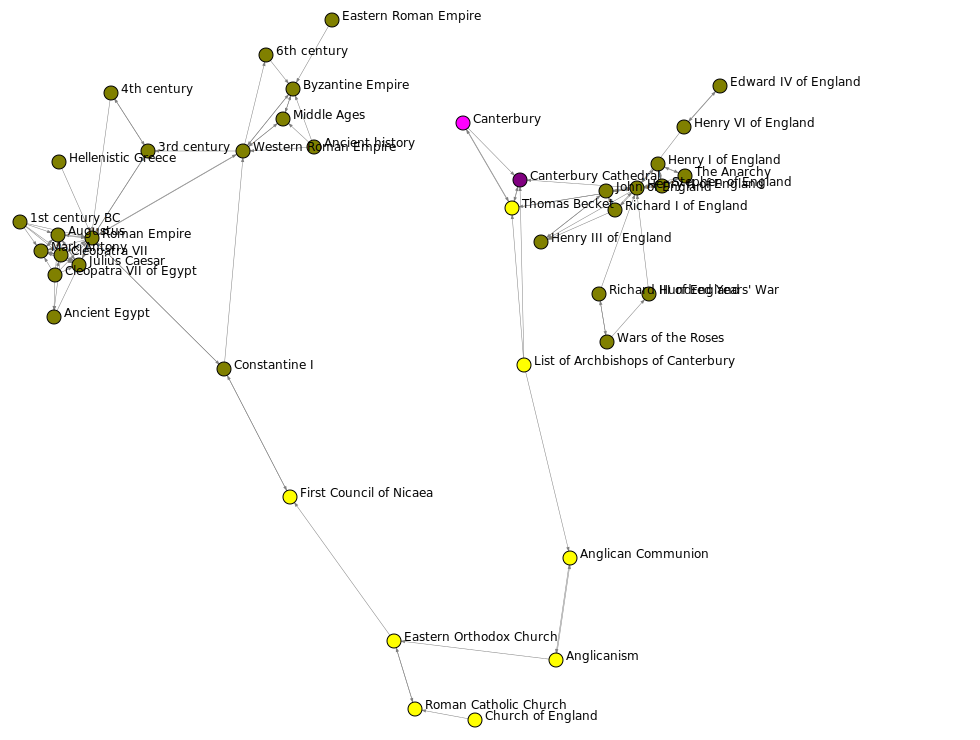

In [1736]:
# Display random pattern summary
idx = 9
print(f'Pattern summary: {idx}')
display_pattern_summary(summarized_adjacency, summarized_biadjacency, mask, labels_cc_summarized, idx, names, words, labels, width=700, height=700)

## With new pattern summaries 

Not only connected components

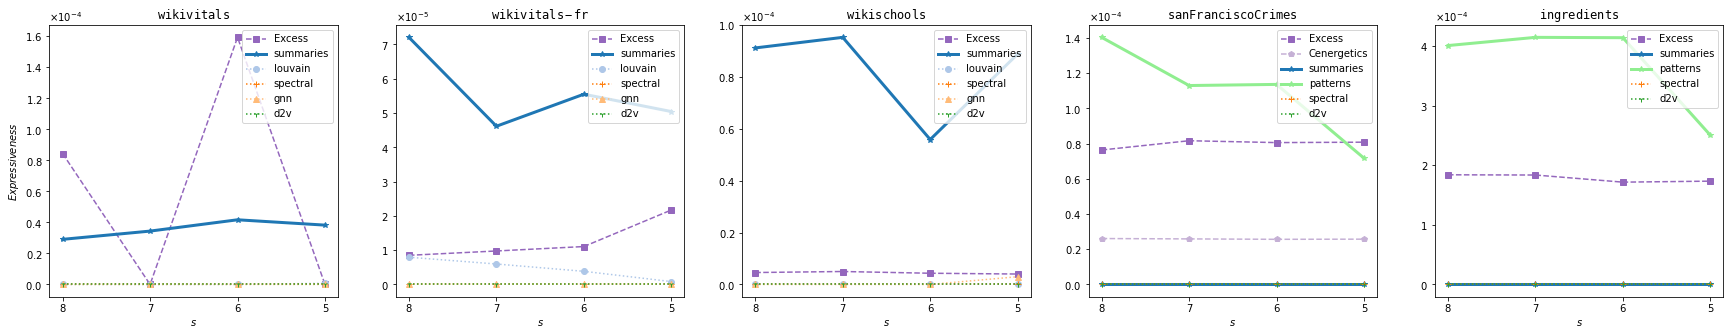

In [1455]:
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

all_inf = defaultdict(list)
all_inf_new = defaultdict(list)

inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/output/result'
expath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/experiments'
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools', 'sanFranciscoCrimes', 'ingredients']
methods = ['summaries', 'louvain', 'spectral', 'gnn', 'd2v']
colors = [plt.cm.Accent(x) for x in range(10)]
#random.shuffle(colors)
markers = ['*', 'o', '+', '^', '1', '2', 's', 'p']

fig, ax = plt.subplots(1, len(datasets), figsize=(30, 5))

for i, d in enumerate(datasets):
    all_inf[d] = defaultdict(list)
    all_inf_new[d] = defaultdict(list)
    if d == 'sanFranciscoCrimes':
        gamma = 0.2
    elif d == 'ingredients':
        gamma = 0.05
    else:
        gamma = 0.8
        
    if d == 'ingredients':
        beta = 1
    else:
        beta = 4
        
    for s in ss:        
        # Excess results
        with open(f'{expath}/Excess/results/{d}/information_details_{d}_5_{s}_{gamma}_excess.txt', 'r') as data:
            info_excess_raw = data.readlines()
        vals = list(map(float, info_excess_raw[0].split(', ')))
        all_inf[d]['excess'].append(clip(vals[3]))
        
        # Cenergetics results
        if d == 'sanFranciscoCrimes':
            with open(f'{expath}/Cenergetics/results/{d}/information_details_{d}_5_{s}_{gamma}_cenergetics.txt', 'r') as data:
                info_cenergetics_raw = data.readlines()
            vals = list(map(float, info_cenergetics_raw[0].split(', ')))
            all_inf[d]['cenergetics'].append(clip(vals[3]))
        
        # Unex patterns + baselines
        for m in methods:
            if (m in ['gnn', 'louvain'] and d == 'ingredients') or (m in ['gnn', 'louvain'] and d == 'sanFranciscoCrimes'):
                pass
            elif not (m == 'gnn' and d=='sanFranciscoCrimes'):
                with open(f'{inpath}/with_prob/new/information_details_{d}_{beta}_{s}_{m}_{gamma}_new_conc.txt', 'r') as data:
                    info = data.readlines()
                vals = list(map(float, info[0].split(', ')))
                all_inf[d][m].append(clip(vals[3]))
                
                with open(f'{inpath}/with_prob/new_summaries/information_details_{d}_{beta}_{s}_{m}_{gamma}_new_conc.txt', 'r') as data:
                    info = data.readlines()
                vals = list(map(float, info[0].split(', ')))
                all_inf_new[d][m].append(clip(vals[3]))
                
                # Also plot pattern information
                if m == 'summaries' and d in ['sanFranciscoCrimes', 'ingredients']:
                    with open(f'{inpath}/with_prob/new_summaries/information_details_{d}_{beta}_{s}_patterns_{gamma}_new_conc.txt', 'r') as data:
                        info = data.readlines()
                    vals = list(map(float, info[0].split(', ')))
                    all_inf_new[d]['patterns'].append(clip(vals[3]))
                    

    ax[i].plot(np.arange(0, 4), all_inf[d]['excess'], label='Excess', color=colors[-2], marker=markers[-2], linestyle='dashed')
    if d == 'sanFranciscoCrimes':
        ax[i].plot(np.arange(0, 4), all_inf[d]['cenergetics'], label='Cenergetics', color=colors[-1], marker=markers[-1], linestyle='dashed')
    
    # Baselines
    for j, m in enumerate(methods):
        if (m in ['gnn', 'louvain'] and d == 'ingredients') or (m in ['gnn', 'louvain'] and d == 'sanFranciscoCrimes'):
            pass
        elif not (m == 'gnn' and d=='sanFranciscoCrimes'):
            if m == 'summaries':
                #ax[i].plot(np.arange(0, 4), all_inf[d][m], label='UnexPatterns orig', marker=markers[j], color='black', linewidth=3)
                ax[i].plot(np.arange(0, 4), all_inf_new[d][m], label=m, marker=markers[j], color=colors[j], linewidth=3)
                if d in ['sanFranciscoCrimes', 'ingredients']:
                    ax[i].plot(np.arange(0, 4), all_inf_new[d]['patterns'], label='patterns', marker=markers[j], color='lightgreen', linewidth=3)
            else:
                #ax[i].plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linestyle='dotted')
                ax[i].plot(np.arange(0, 4), all_inf_new[d][m], label=m, marker=markers[j], color=colors[j], linestyle='dotted')
    ax[i].set_title(rf'$\tt{d}$')
    ax[i].set_xticks(np.arange(0, 4), ss)
    ax[i].legend()
    ax[i].set_xlabel(r'$s$')
    
    if i==0:
        ax[i].set_ylabel(rf'$Expressiveness$')
    #ax[i].ticklabel_format(axis='y', style='sci')
    ax[i].yaxis.set_major_formatter(formatter) 
    ax[i].legend(loc='upper right')

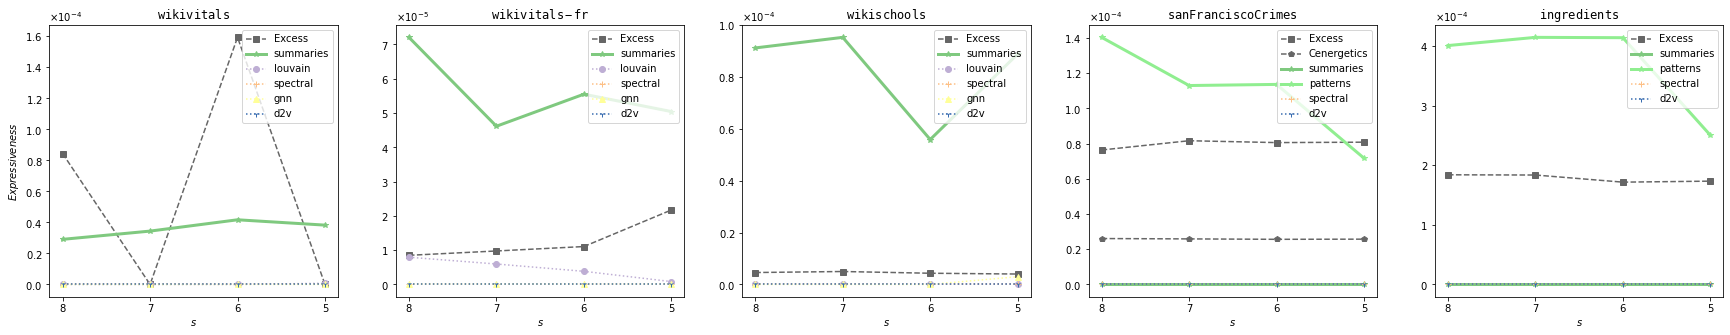

In [1508]:
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

all_inf = defaultdict(list)
all_inf_new = defaultdict(list)

inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/output/result'
expath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/experiments'
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools', 'sanFranciscoCrimes', 'ingredients']
methods = ['summaries', 'louvain', 'spectral', 'gnn', 'd2v']
colors = [plt.cm.Accent(x) for x in range(10)]
#random.shuffle(colors)
markers = ['*', 'o', '+', '^', '1', '2', 's', 'p']

fig, ax = plt.subplots(1, len(datasets), figsize=(30, 5))

for i, d in enumerate(datasets):
    all_inf[d] = defaultdict(list)
    all_inf_new[d] = defaultdict(list)
    if d == 'sanFranciscoCrimes':
        gamma = 0.2
    elif d == 'ingredients':
        gamma = 0.05
    else:
        gamma = 0.8
        
    if d == 'ingredients':
        beta = 1
    else:
        beta = 4
        
    for s in ss:        
        # Excess results
        with open(f'{expath}/Excess/results/{d}/information_details_{d}_5_{s}_{gamma}_excess.txt', 'r') as data:
            info_excess_raw = data.readlines()
        vals = list(map(float, info_excess_raw[0].split(', ')))
        all_inf[d]['excess'].append(clip(vals[3]))
        
        # Cenergetics results
        if d == 'sanFranciscoCrimes':
            with open(f'{expath}/Cenergetics/results/{d}/information_details_{d}_5_{s}_{gamma}_cenergetics.txt', 'r') as data:
                info_cenergetics_raw = data.readlines()
            vals = list(map(float, info_cenergetics_raw[0].split(', ')))
            all_inf[d]['cenergetics'].append(clip(vals[3]))
        
        # Unex patterns + baselines
        for m in methods:
            if (m in ['gnn', 'louvain'] and d == 'ingredients') or (m in ['gnn', 'louvain'] and d == 'sanFranciscoCrimes'):
                pass
            elif not (m == 'gnn' and d=='sanFranciscoCrimes'):
                with open(f'{inpath}/with_prob/new/information_details_{d}_{beta}_{s}_{m}_{gamma}_new_conc.txt', 'r') as data:
                    info = data.readlines()
                vals = list(map(float, info[0].split(', ')))
                all_inf[d][m].append(clip(vals[3]))
                
                with open(f'{inpath}/with_prob/new_summaries/information_details_{d}_{beta}_{s}_{m}_{gamma}_new_conc.txt', 'r') as data:
                    info = data.readlines()
                vals = list(map(float, info[0].split(', ')))
                all_inf_new[d][m].append(clip(vals[3]))
                
                # Also plot pattern information
                if m == 'summaries' and d in ['sanFranciscoCrimes', 'ingredients']:
                    with open(f'{inpath}/with_prob/new_summaries/information_details_{d}_{beta}_{s}_patterns_{gamma}_new_conc.txt', 'r') as data:
                        info = data.readlines()
                    vals = list(map(float, info[0].split(', ')))
                    all_inf_new[d]['patterns'].append(clip(vals[3]))
                    

    ax[i].plot(np.arange(0, 4), all_inf[d]['excess'], label='Excess', color=colors[-2], marker=markers[-2], linestyle='dashed')
    if d == 'sanFranciscoCrimes':
        ax[i].plot(np.arange(0, 4), all_inf[d]['cenergetics'], label='Cenergetics', color=colors[-1], marker=markers[-1], linestyle='dashed')
    
    # Baselines
    for j, m in enumerate(methods):
        if (m in ['gnn', 'louvain'] and d == 'ingredients') or (m in ['gnn', 'louvain'] and d == 'sanFranciscoCrimes'):
            pass
        elif not (m == 'gnn' and d=='sanFranciscoCrimes'):
            if m == 'summaries':
                #ax[i].plot(np.arange(0, 4), all_inf[d][m], label='UnexPatterns orig', marker=markers[j], color='black', linewidth=3)
                ax[i].plot(np.arange(0, 4), all_inf_new[d][m], label=m, marker=markers[j], color=colors[j], linewidth=3)
                if d in ['sanFranciscoCrimes', 'ingredients']:
                    ax[i].plot(np.arange(0, 4), all_inf_new[d]['patterns'], label='patterns', marker=markers[j], color='lightgreen', linewidth=3)
            else:
                #ax[i].plot(np.arange(0, 4), all_inf[d][m], label=m, marker=markers[j], color=colors[j], linestyle='dotted')
                ax[i].plot(np.arange(0, 4), all_inf_new[d][m], label=m, marker=markers[j], color=colors[j], linestyle='dotted')
    ax[i].set_title(rf'$\tt{d}$')
    ax[i].set_xticks(np.arange(0, 4), ss)
    ax[i].legend()
    ax[i].set_xlabel(r'$s$')
    
    if i==0:
        ax[i].set_ylabel(rf'$Expressiveness$')
    #ax[i].ticklabel_format(axis='y', style='sci')
    ax[i].yaxis.set_major_formatter(formatter) 
    ax[i].legend(loc='upper right')

In [1515]:
all_inf_new.get('wikivitals-fr').get('summaries')

[7.206556523490712e-05,
 4.6146658419313355e-05,
 5.549175789412938e-05,
 5.042537006848348e-05]

In [1516]:
all_inf.get('wikivitals-fr').get('summaries')

[5.7509932869521615e-05,
 7.583571039399792e-05,
 5.0627039226419e-05,
 5.4642209018263245e-05]

In [749]:
inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/output/result'
s = 5
dataset = 'wikivitals'
delta = 0.5

   
# Unex patterns distances
with open(f'{inpath}/with_prob/new/wasserstein_distances_{dataset}_4_{s}_summaries.pkl', 'rb') as data:
    distances = np.load(data)
n = distances.shape[0]
print(np.min(distances), np.max(distances))
upper = distances[np.triu_indices(n)]
nb_ps = np.sum(upper > delta)
print(f'Unex patterns diversity: {nb_ps / len(upper):.4f}')

# Excess distnaces
with open(f'{inpath}/wasserstein_distances_{dataset}_5_{s}_excess_patterns.pkl', 'rb') as data:
    distances_excess = np.load(data)
print(np.min(distances_excess), np.max(distances_excess))
n = distances_excess.shape[0]
upper = distances_excess[np.triu_indices(n)]
nb_ps = np.sum(upper > delta)
print(f'Excess diversity: {nb_ps / len(upper):.4f}')

0.07548724412918091 4.174521325776975
Unex patterns diversity: 0.9378
0.04831776283681392 0.04831776283681392
Excess diversity: 0.0000


In [920]:
inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/output/result/with_prob'
with open(f'{inpath}/result_wikischools_4_5_orderTrue_prob.bin', 'rb') as f:
    p_unex = pickle.load(f)
    
print(f'Number of patterns: {len(p_unex)}')

Number of patterns: 3817


In [1329]:
d = 'wikivitals'
adjacency, biadjacency, names, names_col, labels = load_data(d)
print(adjacency.nnz)
# Load patterns
inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/output/result'
with open(f'{inpath}/result_{d}_5_5_orderTrue.bin', 'rb') as f:
    p_unex = pickle.load(f)
print(f'Number of patterns: {len(p_unex)}')

# Build summarized adjacency matrix, i.e. adjacency matrix of the union of all patterns found with UnexPatterns
summarized_adj = get_summarized_graph(adjacency, p_unex)
print(summarized_adj.shape, summarized_adj.nnz)

# Summarized graph filtered on used nodes
#mask = np.flatnonzero(summarized_adj.astype(bool).dot(np.ones(summarized_adj.shape[1])))

# Number of connected components (NOT considering isolated nodes)
#labels_cc_summarized = get_connected_components(summarized_adj[mask, :][:, mask])
#nb_cc = len(np.unique(labels_cc_summarized)) 

#print(f'Number of pattern summaries: {nb_cc}')

Parsing files...
Done.
824999
Number of patterns: 1116
(10011, 10011) 3465


In [1360]:
%%time

mix_p = defaultdict(set)
mix_attr = defaultdict(set)

for i, p in enumerate(p_unex):
    improved = True
    if len(p[1]) > 0:
        mix_p[i] = set(p[0])
        mix_attr[i] = set(p[1])
        #print(f'i={i}, {sorted(mix_p[i])}')
        while improved:
            improved = False
            for j, p2 in enumerate(p_unex):
                if len(p2[1]) > 0:
                    common_nodes = mix_p[i].intersection(p2[0])
                    if len(common_nodes) > 0 :
                        union = mix_p[i].union(set(p2[0]))
                        if len(union) > len(mix_p[i]):
                            improved=True
                            mix_p[i] |= set(p2[0])
                            mix_attr[i] |= set(p2[1])
                            #print(f'  j={j}, new length: {len(mix_p[i])}')
    #if i > 10:
    #    break
print(len(mix_p))

1115
CPU times: user 1.67 s, sys: 3.03 ms, total: 1.67 s
Wall time: 1.67 s


In [1362]:
all_res = []
all_idx = []
for i, s in mix_p.items():
    if s not in all_res:
        all_res.append(s)
        all_idx.append(i)
print(len(all_res))

87


In [1395]:
def get_pattern_summaries_new(patterns: list) -> list:
    """Pattern summaries are the union of pattern nodes and attributes which share at least one common node.
    
    Parameters
    ----------
    patterns: list
        List of patterns (X,Q).
        
    Outputs
    -------
        List of pattern summaries. """

    nodes_p = defaultdict(set)
    attrs_p = defaultdict(set)

    for i, p1 in enumerate(patterns):
        improved = True 
        if len(p1[1]) > 0:
            nodes_p[i] = set(p1[0])
            attrs_p[i] = set(p1[1])
            
            # For a given pattern, loop over patterns until no more pattern can be merged
            while improved:
                improved = False
                for j, p2 in enumerate(patterns):
                    if len(p2[1]) > 0:
                        # Find common nodes between patterns
                        common_nodes = nodes_p[i].intersection(p2[0])
                        if len(common_nodes) > 0 :
                            # Merge patterns
                            union = nodes_p[i].union(set(p2[0]))
                            if len(union) > len(nodes_p[i]):
                                improved=True
                                nodes_p[i] |= set(p2[0])
                                attrs_p[i] |= set(p2[1])
    
    # Remove duplicate pattern summaries
    p_s_nodes = []
    indexes = []
    for i, s in nodes_p.items():
        if s not in p_s_nodes:
            p_s_nodes.append(s)
            indexes.append(i)
    
    # Build deduplicated list of pattern summaries with nodes and attributes
    pattern_summaries = [(list(n), list(attrs_p.get(i))) for n, i in zip(p_s_nodes, indexes)]
    
    return pattern_summaries

In [1396]:
pattern_summaries = get_pattern_summaries_new(p_unex)

In [1405]:
matrix = np.zeros((nb_p_s, biadjacency.shape[1]))
for i, p_s in enumerate(pattern_summaries):
    for attr in p_s[1]:
        matrix[i, attr] += 1

In [1407]:
matrix.shape

(87, 20527)

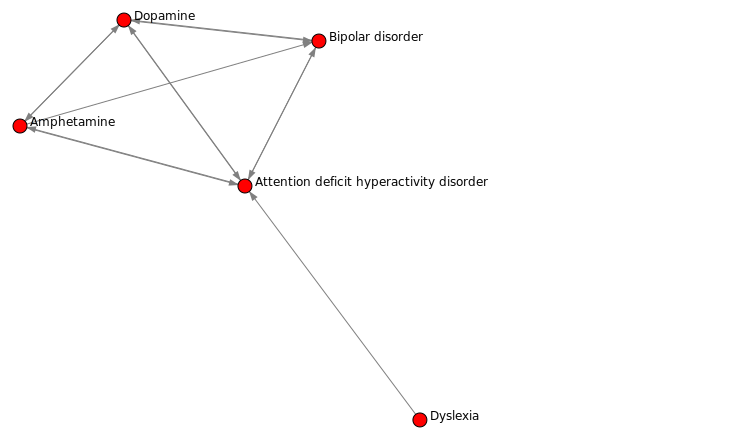

In [1351]:
idx = 43 #np.random.choice(len(all_res))
nodes = list(all_res[idx])
SVG(svg_graph(summarized_adj[nodes, :][:, nodes], labels=labels[nodes], names=names[nodes],
              edge_width_max=1, height=400))

In [1333]:
np.argsort([-len(p) for p in all_res])

array([10, 18, 27, 13,  3, 69, 28, 26, 86, 84,  9, 71, 62, 21, 40, 38, 15,
       64, 42, 85, 34,  0,  1,  7, 33, 83, 82, 81, 80, 79, 78, 49, 72, 73,
       70, 75, 76, 77, 74, 58, 59, 60, 61,  6, 63, 22, 65, 66, 67, 68,  4,
       57,  2,  5, 56, 54, 20, 23, 24, 25, 19, 17, 16, 29, 30, 31, 32, 14,
       35, 36, 55, 37, 39, 11, 41,  8, 44, 45, 46, 47, 48, 50, 51, 52, 53,
       12, 43])

In [588]:
print(np.mean([len(x[0]) for x in p_unex[1:]]))
print(np.mean([len(x[1]) for x in p_unex[1:]]))

5.643013100436681
9.436681222707424


In [571]:
inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/experiments/Excess/results/'
with open(f'{inpath}/wikischools/retrievedPatterns_5.json', 'rb') as f:
    data = json.load(f)
    
p_excess = data.get('patterns')
print(f'Number of patterns: {len(p_excess)}')
idx = 6
print(len(p_excess[idx].get('subgraph')))
print(len(p_excess[idx].get('characteristic')))

Number of patterns: 7679
115
4


In [586]:
a_avg, n_avg = [], []
for i in p_excess:
    n_avg.append(len(i.get('subgraph')))
    a_avg.append(len(i.get('characteristic')))
print(np.mean(n_avg), np.mean(a_avg))

63.96496939705691 4.0


In [480]:
adjacency

<4403x4403 sparse matrix of type '<class 'numpy.bool_'>'
	with 112834 stored elements in Compressed Sparse Row format>

Parsing files...
Done.


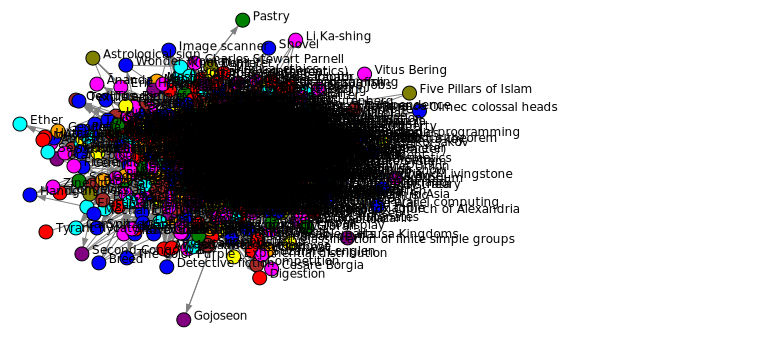

In [488]:
idx = 5
# Load netset data
adjacency, biadjacency, names, names_col, labels = load_data('wikivitals')

e_nodes = [int(x) for x in p_excess[idx].get('subgraph')]
SVG(svg_graph(adjacency[e_nodes, :][:, e_nodes], names=names[e_nodes], labels=labels[e_nodes]))

In [893]:
from collections import Counter

def plot_distrib(values, ax, xlabel='degree', log=True, title=None, color='blue', alpha=1, label='Degree distribution'):
    counter = Counter(values)
    x, y = zip(*counter.items())
    ax.scatter(x, y, marker='+', color=color, alpha=alpha, label=label)
    ax.legend()
    ax.set_title(title)
    if log:
        ax.set_xscale('log')
        ax.set_xlabel(xlabel + ' (log)')
        ax.set_yscale('log')
        ax.set_ylabel('Frequency' + ' (log)')
    else:
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Frequency')
    

Parsing files...
Done.
Parsing files...
Done.
Parsing files...
Done.


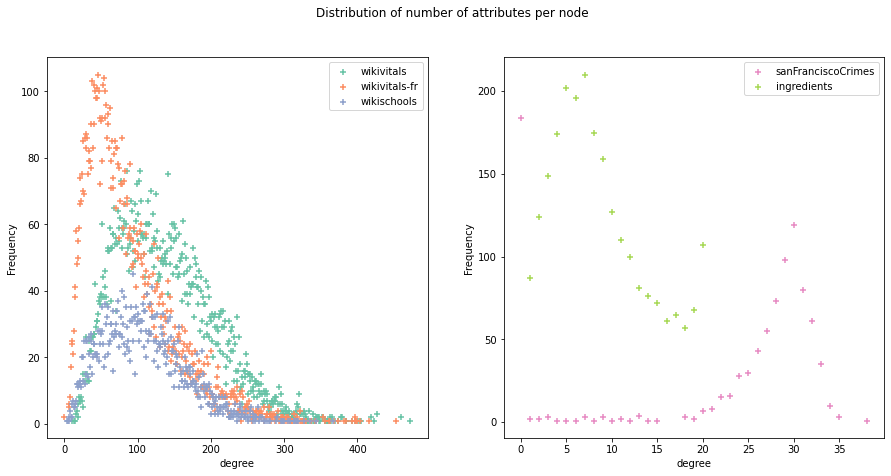

In [900]:
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools', 'sanFranciscoCrimes', 'ingredients']
colors = [plt.cm.Set2(x) for x in range(len(datasets))]

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
plt.suptitle('Distribution of number of attributes per node')
for i, d in enumerate(datasets):
    adjacency, biadjacency, names, names_col, _ = load_data(d)
    degs = get_degrees(biadjacency, transpose=False)
    if d in ['wikivitals', 'wikivitals-fr', 'wikischools']:
        plot_distrib(degs, ax[0], color=colors[i], log=False, label=d)
    else:
        plot_distrib(degs, ax[1], color=colors[i], log=False, label=d)

Parsing files...
Done.
Parsing files...
Done.
Parsing files...
Done.


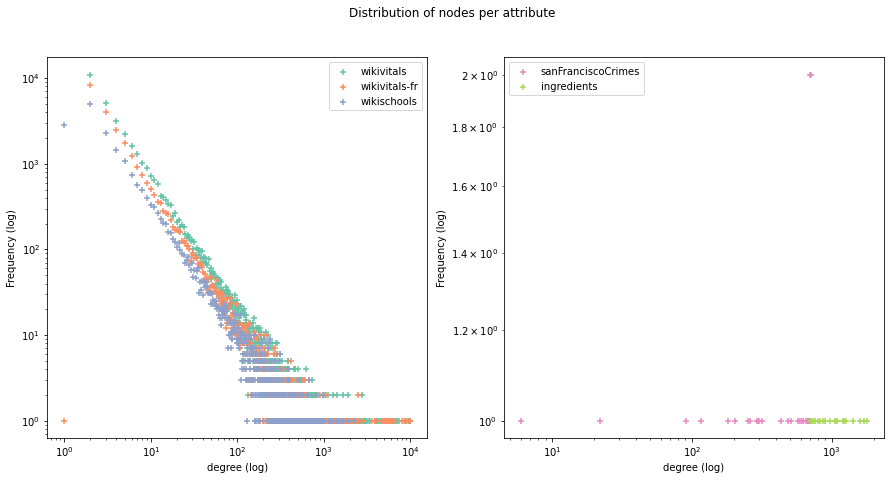

In [903]:
datasets = ['wikivitals', 'wikivitals-fr', 'wikischools', 'sanFranciscoCrimes', 'ingredients']
colors = [plt.cm.Set2(x) for x in range(len(datasets))]

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
plt.suptitle('Distribution of nodes per attribute')
for i, d in enumerate(datasets):
    adjacency, biadjacency, names, names_col, _ = load_data(d)
    degs = get_degrees(biadjacency, transpose=True)
    if d in ['wikivitals', 'wikivitals-fr', 'wikischools']:
        plot_distrib(degs, ax[0], color=colors[i], log=True, label=d)
    else:
        plot_distrib(degs, ax[1], color=colors[i], log=True, label=d)